Контакты: Олеся Круглякова, телеграм @inogdazdes

# Стоимость поддержанного автомобиля

**Соревнование Kaggle**

**Описание задачи:**

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

**Задача:**

Разработать модель для предсказания стоимости продажи автомобиля на вторичном рынке.

**Объект исследования:**

Данные с сервиса по продаже поддержанных автомобилей с их характеристиками.


**План проекта:**

В ходе работы в пройдете все основные этапы полноценного исследования:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.



## Импорт библиотек

In [1]:
# !pip install kaggle
# # библиотека кофээфициент кореляции фи
# !pip install phik
# # установка библиотеки для кодирования TargetEncoder
# !pip install category_encoders
# # библиотека важность признаков
# !pip install shap
# !pip install vininfo[cli]
# pip install numpy==1.21.6

In [2]:
# !kaggle competitions download -c used-cars-price-prediction-22ds

In [394]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

# для корреляции
import phik
from phik.report import plot_correlation_matrix
from scipy.stats import chi2, chi2_contingency

# деление на выборки
from sklearn.model_selection import train_test_split

# масштабирование и кодирование
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

# кластеризация
from sklearn.cluster import KMeans

# создание константной модели
from sklearn.dummy import DummyClassifier

# модели 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Ridge, Lasso
# уменьшение размерности
from sklearn.decomposition import PCA

# модель градиентный бустинг из библиотеки catboost
import catboost as cb

# метрика классификации, матрица ответов
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer

# подбор гипрепараметров, расчёт метрики на кросс-валидации
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score


# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# заполнение пропусков
from sklearn.impute import KNNImputer, SimpleImputer

# скрыть предупреждения
import warnings
warnings.filterwarnings('ignore')

# вывод HTML, отображение таблиц рядом
from IPython.display import display_html, HTML

# расчёт и интерпретация важности признаков
import shap

# автоматизированный анализ датасета
from ydata_profiling import ProfileReport

# библиотека с vin номерами
from vininfo import Vin



In [4]:
# настроим отображение таблиц
# убрать ограничение на количество отображаемых столбцов
pd.options.display.max_columns = None
# 2 цифры после запятой
pd.options.display.precision = 2

In [5]:
# зададим переменную с начальным состоянием генератора случайности 
RANDOM_STATE = 42

## Загрузка и знакомство с данными

**Предоставленные данные**

- `train.csv` - информация о характеристиках автомобилей (~440 тыс.), которые будут использоваться в качестве обучающих данных
- `test.csv` - информация о характеристиках автомобилей (~110 тыс.), которые будут использоваться в качестве тестовых данных

In [196]:
# возможные пути расположения файла
kaggle_path = '/kaggle/input/used-cars-price-prediction-22ds/'
local_path = 'used-cars-price-prediction-22ds/'

# проверка, какой путь существует
if os.path.exists(kaggle_path):
    path = kaggle_path
    print('server path')
elif os.path.exists(local_path):
    path = local_path
    print('local path')
else:
    print('Неправильно указан путь к файлу')
    
    
# загружаем таблицы
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')


local path


In [175]:
# сохранм исходные датасеты
train_df_original = train_df.copy()
test_df_original = test_df.copy()

In [176]:
# смотрим на содержимое
train_df.sample(5)

year       make   model trim   body transmission                vin  \
284379  2004        NaN     NaN  NaN    NaN    automatic  wdbrf61j14e015761   
262642  2009  Chevrolet  Malibu  LTZ  Sedan    automatic  1g1zk57b89f188176   
62835   2010  Chevrolet  Camaro  2LT  Coupe    automatic  2g1fc1ev0a9194265   
161186  2009     Nissan  Armada   SE    SUV    automatic  5n1aa08d89n601824   
393991  2013     Nissan  Altima  2.5  Sedan    automatic  1n4al3ap9dc915870   

       state  condition  odometer   color interior  \
284379    tx        2.0  140447.0  silver    black   
262642    ca        3.2   80364.0  silver    black   
62835     tn        3.3   65156.0  orange    black   
161186    hi        2.2  104531.0   black        —   
393991    fl        4.9   36674.0   white    black   

                                          seller  sellingprice  \
284379  remarketing by ge/nas financial services          3000   
262642                          inland chevrolet          8100   
62835                         santander consumer         15200   
161186    remarketing by ge/alliant credit union          9200   
393991                        nissan-infiniti lt         15600   

                                       saledate  
284379  Thu Feb 19 2015 11:00:00 GMT-0800 (PST)  
262642  Thu Mar 05 2015 04:00:00 GMT-0800 (PST)  
62835   Tue Jan 27 2015 02:30:00 GMT-0800 (PST)  
161186  Wed Jan 07 2015 06:30:00 GMT-0800 (PST)  
393991  Wed Mar 04 2015 01:00:00 GMT-0800 (PST)

**Описание признаков:**
- `Date`: Год выпуска автомобиля
- `Make`: Бренд автомобиля
- `Model`: Модель автомобиля
- `Trim`: Уровни отделки салона автомобиля, комплектация
- `Body`: Тип кузова
- `Transmission`: Коробка передач
- `VIN`: Идентификационный номер транспортного средства
- `State`: Штат (регион)
- `Condition`: Оценка состояния автомобиля на момент аукциона
- `Odometer`: Пробег
- `Color`: Цвет кузова автомобиля
- `Interior`: Цвет салона автомобиля
- `Seller`: Продавец автомобиля, автосалоны
- `saledate`: Дата продажи автомобиля

**Целевой признак:**
- **`sellingprice`**: цена, по которой автомобиль был продан на аукционе 

Познакомимся с данными, оценим их на полноту, корректность типов данных и наличие дубликатов

In [177]:
# размеры выборок
print('Обучающая выборка: ', train_df.shape, '\nТестовая выборка: ', test_df.shape)

Обучающая выборка:  (440236, 15) 
Тестовая выборка:  (110058, 14)


In [178]:
# выведем пропуски, их долю и типы данных для обеих выборок
print('Пропуски и типы данных:')
nan_type_table = pd.DataFrame({'TRAIN Quantity' : train_df.isna().sum(),
                'TRAIN Percent' : train_df.isna().mean() * 100,
                'TRAIN Types' : train_df.dtypes,
                'TEST Quantity' : test_df.isna().sum().astype('int'),
                'TEST Percent' : test_df.isna().mean() * 100,
                'TEST Types' : test_df.dtypes}
            )
nan_type_table.style.background_gradient().set_precision(2)


Пропуски и типы данных:



Доли пропущенных значений по признакам равнозначны в обучающей и тестовой выборках:
- Значительная доля пропусков в `transmission` ~12%
- ~2% в признаках `body`, `condition`, `make`, `model`,`trim`
- ~0.1%в признаках `color`, `interior`, `odometer`

По типам данных нужно конвертировать `saledate` в datetime

Проверим дубликаты

In [179]:
# проверка на явные дубликаты
print(f'Дубликаты: train - {train_df.duplicated().sum()} строк, test - {test_df.duplicated().sum()} строк')
# проверка на  дубликаты в vin номере
print(f'Дубликаты в vin-номере: train - {train_df["vin"].duplicated().sum()}, test - {test_df["vin"].duplicated().sum()}')


Дубликаты: train - 0 строк, test - 0 строк
Дубликаты в vin-номере: train - 0, test - 0


Изучим признаки с помощью комплексного отчёта ProfileReport

In [15]:
# автоматизированный анализ датасета
profile_train = ProfileReport(train_df, title="Train Data Profiling Report")
profile_train.to_file("train_profile.html")
# загружаем HTML
HTML(filename="train_profile.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Числовые признаки:
- `year` данные полные и без выбросов
- `condition`: пропуски, диапазон от 1 до 5 баллов, выбросов нет
- `odometer`: лишь 69 пропусков, диапазон скорее всего указывает на ограничение в системе на ввод от 1 до 999999, есть подозрительно низкие и высокие значения

Категориальные:
- `make`: 92 уникальных значения, пропуски,  дубликаты из-за заглавных букв
- `model`: 959 уникальных значения, пропуски, дубликаты из-за заглавных букв
- `trim`: 1922 уникальных значения, пропуски, дубликаты из-за заглавных букв
- `body`: 85 уникальных значений, пропуски 2.4%, дубликаты из-за заглавных букв
- `transmission`: 2 уникальных значения: automatic 85% и manual 3%, большой процент пропусков 11.7%
- `state`: 38 уникальных значения, данные полные
- `color`: 20 уникальных значений, 0,1% пропущенных
- `interior`: 17 уникальных значений, 0,1% пропусков
- `seller`: 13025 уникальных значений

Даты:
- `seledate`: изменим тип данных, проанализируем подробней далее

Целевой признак:
- `sellingprice`: 
    - диаппазон 1 - 230 000 у.е., среднее 15592, а медиана 12100 у.е., 90% объектов расположено в диапазоне 1500-30600
    - уникальных значений всего 1735 - часто округлённые
    - удалим 2 объекта с ценой 1 у.е., оставив минимальным 100 у.е., и оценим самые высокие
      
      
- Достаточно высокая корреляция между целевым признаком `sellingprice`, а также между собой у года `year`, пробега `odometer`, состояния `condition`. Небольшая связь цены и производителя `sellingprice`-`make`, трансмиссии и кузова `transmission`-`body`.

- Пропуски по 4 признакам `make`, `body`, `trim`, `model` для одних объектов


## Предобработка данных
\*Поверхностный анализ содержания признаков, первичная предобработка и добавление новых признаков собраны в функцию:
- исправлен формат даты `saledate`
- значения категориальных признаков приведены к нижнему регистру`make`, `model`, `trim`, `body`
- пропуски в бренде `make` заполнены с помощью `vin` и библиотеки vininfo
- пропуски в `model` заполнены пустым значением
- пропуски в `color`, `interior` заполнены уже имеющимся среди категорий прочерком
- созданы новые признаки:
    - ~~возраст автомобиля `age` - разница между годом выпуска и годом продажи~~
    - `modek_with_brand` - не новый, а дополненный брендом признак с моделью
- установили индексом `vin`
 

In [197]:
def preprocess_df(df):
    """Функция для предобработки данных для анализа"""
    
    # изменить формат даты
    df['saledate'] = pd.to_datetime(df['saledate'], utc=True)
    
    # функция выдаёт производителя по vin
    def find_brand_in_vin(vin):
        vin = Vin(vin)
        return vin.manufacturer
    # заполнить пропущенные бренды машин по vin-номеру
    df['make'] = df.apply(lambda row: find_brand_in_vin(row['vin']) if pd.isna(row['make']) else row['make'], axis=1)

    # изменить регистр на нижний
    for col in ['make', 'model', 'trim', 'body']:
        df[col] = df[col].str.lower()

    # пропуски пустой строкой в моделе
    df['model'] = df['model'].fillna('')


    # заменим пропуски на уже имеющийся знак пропуска - какое-то особенное тире (скопировано) в цветах кузова и салона
    df[['color', 'interior']] = df[['color', 'interior']].fillna('—')

#     # НОВЫЙ ПРИЗНАК age возраст автомобиля
#     df['age'] = df['saledate'].dt.year - df['year']
#     # заменим -1 на 0
#     df['age'] = df['age'].where(df['age'] > 0, 0)
    
    
    # НОВЫЙ ПРИЗНАК, объединяющего модель и бренд
    df['model_with_brand'] = df['make'] + ' ' + df['model']
    
    # установить индекс
    df = df.set_index('vin')
    
    return df


In [198]:
# предобработаем сразу 2 датасета
train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)

##  Исследовательский анализ данных
Разберём каждый признак и проанализируем его взаимосвязь с целевым.
### Дата
Проанализируем данные относительно даты.


In [183]:
# вычислим периоды
train_first_date = train_df['saledate'].dt.date.min()
train_last_date = train_df['saledate'].dt.date.max()
test_first_date = test_df['saledate'].dt.date.min()
test_last_date = test_df['saledate'].dt.date.max()

print(f"""
Период дат продажи: 
train:  {train_first_date} - {train_last_date}, test: {test_first_date} - {test_last_date}
Количество дней между датами: 
train: {train_last_date - train_first_date}, test: {test_last_date - test_first_date}
Количество уникальных дат: 
train: {train_df['saledate'].dt.date.value_counts().count()}, test: {train_df['saledate'].dt.date.value_counts(
                                                                                                    ).count()}""")


Период дат продажи: 
train:  2014-01-01 - 2015-07-20, test: 2014-01-01 - 2015-07-13
Количество дней между датами: 
train: 565 days, 0:00:00, test: 558 days, 0:00:00
Количество уникальных дат: 
train: 174, test: 174


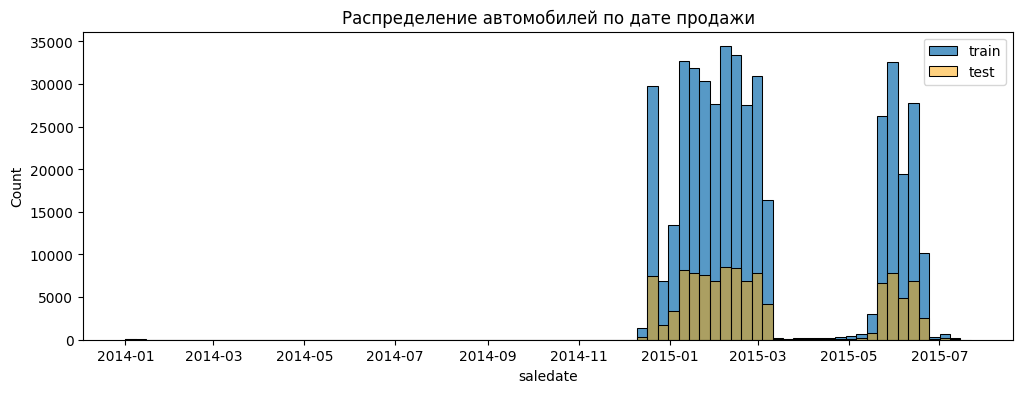

In [15]:
# гистограмма по дате продажи
plt.figure(figsize=(12,4))
sns.histplot(data=train_df['saledate'], binwidth=7)
sns.histplot(data=test_df['saledate'], binwidth=7, color='orange', alpha=0.5)
plt.title('Распределение автомобилей по дате продажи')
plt.legend(['train', 'test'])
None

In [16]:
# даты до 2015-01
train_df[train_df['saledate'] < '2014-12-31']['saledate'].dt.date.value_counts().sort_index()

2014-01-01       43
2014-01-02       12
2014-01-05        3
2014-01-06       39
2014-01-07       30
2014-01-08       14
2014-01-12       18
2014-01-13        3
2014-01-14        1
2014-01-15        1
2014-01-28        1
2014-12-16     1318
2014-12-17     3871
2014-12-18    13626
2014-12-19     3153
2014-12-21       18
2014-12-22     1296
2014-12-23     7959
2014-12-24       39
2014-12-26      160
2014-12-28       13
2014-12-29      555
2014-12-30     5990
Name: saledate, dtype: int64

- Данные предоставлены за небольшой период: большинство объектов с датой продажи 2014-12 - 2015-07 с понижением в период 2015-03 - 2015-05 + маленькая часть в 2014-01 
- В обеих выборках объекты похоже распределены по датам

Проанализируем целевой признак и попробуем найти, что на него влияет.


### Целевой признак `sellingprice`

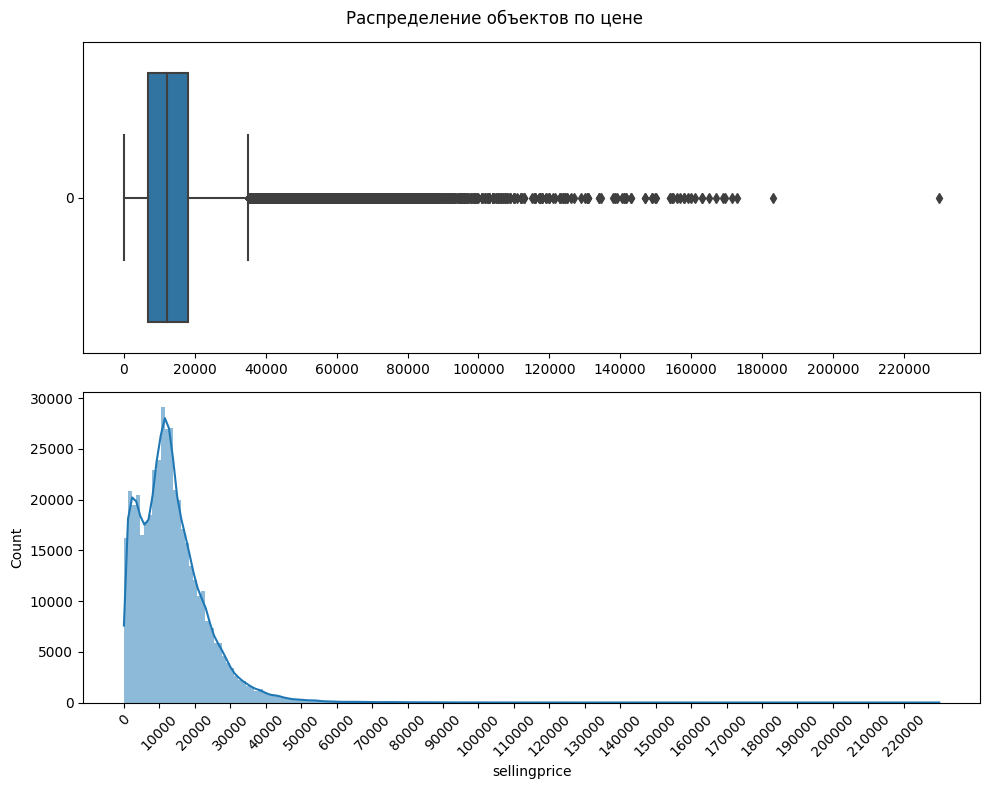

In [186]:
# графики распределения
fig, axs = plt.subplots(2,1, figsize=(10,8))
# ящик с усами на  графике слева
sns.boxplot(data=train_df['sellingprice'], ax=axs[0], orient='h').set_xticks(range(0, 230000, 20000))
# гистограммы на втором
sns.histplot(data=train_df['sellingprice'], kde=True, bins=200, edgecolor=None)
plt.xticks(range(0, 230000, 10000), rotation=45)
plt.suptitle(f'Распределение объектов по цене')
plt.tight_layout()
plt.show()

- Большинство объектов имеет цену до 30 тыс. у.е.
- Как указано при знакомстве с данными, удалим 2 объекта с ценой 1 у.е., так как не предполпгаем предсказание цены таким низким. Минимальной станет цена 100 у.е.

In [199]:
# отфильтруем значения равные единице
train_df = train_df[train_df['sellingprice']>1]
train_df['sellingprice'].describe().to_frame()

sellingprice
count     440234.00
mean       13592.27
std         9751.46
min          100.00
25%         6900.00
50%        12100.00
75%        18200.00
max       230000.00

Изучим максимальные значения

In [187]:
# объекты с ценой выше 165 тыс.
train_df[train_df['sellingprice']>160000].T

vin                        sca664s52dux52152          wby2z2c58evx64401  \
year                                    2013                       2014   
make                             rolls-royce                        bmw   
model                                  ghost                         i8   
trim                                    base                       base   
body                                   sedan                      coupe   
transmission                       automatic                  automatic   
state                                     fl                         ca   
condition                                4.2                        4.4   
odometer                              7852.0                      303.0   
color                                  white                      white   
interior                               beige                       gray   
seller            flag/landrover southpointe          phelps auto sales   
sellingprice                          171500                     161000   
saledate           2015-06-16 20:05:00+00:00  2015-02-25 20:30:00+00:00   
age                                        2                          1   
model_with_brand           rolls-royce ghost                     bmw i8   

vin                       wby2z2c59evx64214          sca664l50cux65625  \
year                                   2014                       2012   
make                                    bmw                rolls-royce   
model                                    i8                      ghost   
trim                                   base                        ewb   
body                                  coupe                      sedan   
transmission                      automatic                  automatic   
state                                    ca                         ca   
condition                               5.0                        3.6   
odometer                               60.0                    11832.0   
color                                 white                      white   
interior                              brown                      black   
seller             ferrari of orange county         bentley scottsdale   
sellingprice                         165000                     169000   
saledate          2015-01-14 20:00:00+00:00  2015-06-17 22:30:00+00:00   
age                                       1                          3   
model_with_brand                     bmw i8          rolls-royce ghost   

vin                                      sca664s59cux50803  \
year                                                  2012   
make                                           rolls-royce   
model                                                ghost   
trim                                                  base   
body                                                 sedan   
transmission                                     automatic   
state                                                   ca   
condition                                              4.4   
odometer                                            5215.0   
color                                                white   
interior                                               tan   
seller            financial services remarketing (bmw int)   
sellingprice                                        167000   
saledate                         2015-06-17 22:30:00+00:00   
age                                                      3   
model_with_brand                         rolls-royce ghost   

vin                       sca664s58cux50727  \
year                                   2012   
make                            rolls-royce   
model                                 ghost   
trim                                   base   
body                                  sedan   
transmission                      automatic   
state                                    fl   
condition                         

Премиальные автомобили за одним исключением - самая высокая цена у ford escape

In [20]:
# распределение цены модели ford escape в датасете за исключением 230000
train_df[(train_df['model_with_brand']=='ford escape')&(train_df['sellingprice']<230000)]['sellingprice'].describe()\
        .to_frame().T

count      mean     std    min      25%      50%      75%  \
sellingprice  9446.0  13923.66  5641.2  225.0  10300.0  14900.0  17900.0   

                  max  
sellingprice  40475.0


Пользователь определённо ошибся с количеством нулей в цене. Предлагаю убрать объект с ценой 230 тыс. из обучающего датасета. Судя по характеристикам остальных автомобилей, цены вполне могли быть указаны такими высокими

In [200]:
# удаляем выброс цены
train_df = train_df[train_df['sellingprice']<200000]
train_df['sellingprice'].describe().to_frame()

sellingprice
count     440233.00
mean       13591.78
std         9746.01
min          100.00
25%         6900.00
50%        12100.00
75%        18200.00
max       183000.00

Получили распредеоление цены 100 - 183 тыс. у.е.

### Корреляционный анализ

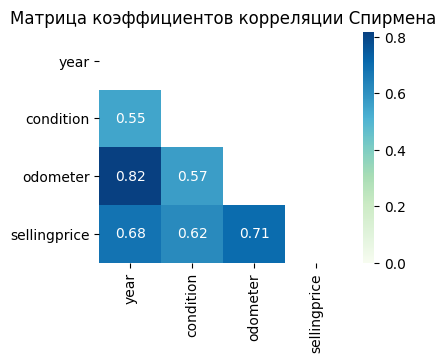

In [201]:
# тепловая матрица линейные зависимости между числовыми
spearman_corr_matrix = train_df.corr(method='spearman').abs()
plt.figure(figsize=(4, 3))
matrix_mask = np.triu(spearman_corr_matrix) # маска, чтобы убрать вернюю треугольную часть с симметричными данными
sns.heatmap(spearman_corr_matrix, annot=True, cmap='GnBu', fmt=".2f", vmin=0,
             mask=matrix_mask)
plt.title('Матрица коэффициентов корреляции Спирмена')
plt.show()

- Все численные признаки имеют линейную зависимость с целевым!
- Высокая корреляция пробега и года выпуска. Оба признака важные, но *мультиколлинеарность* может негативно повлиять на модель 

Теперь посмотрим на коэффициенты сопряженности $\phi_K$, которые зависимостимежду категориальными признаками

In [271]:

def phi_corr_heatmap(df, interval_cols=[]):
    """Функция для построения тепловой карты коэффициентов корреляции фи.
    На вход принимает датасет и список сичленных признаков в датасете"""
    # матрица коэффициентов корреляции фи
    phi_matrix = df.phik_matrix( interval_cols=interval_cols)
    
    ## маска для отображения нижнего треугольника
    phi_matrix_mask = np.triu(np.ones_like(phi_matrix, dtype=bool))

    sns.heatmap(phi_matrix, 
                annot=True, cmap='GnBu', fmt=".2f", vmin=0,
                mask=phi_matrix_mask
               )
#     plt.title('Матрица коэффициентов корреляции $\phi_K$')
    None

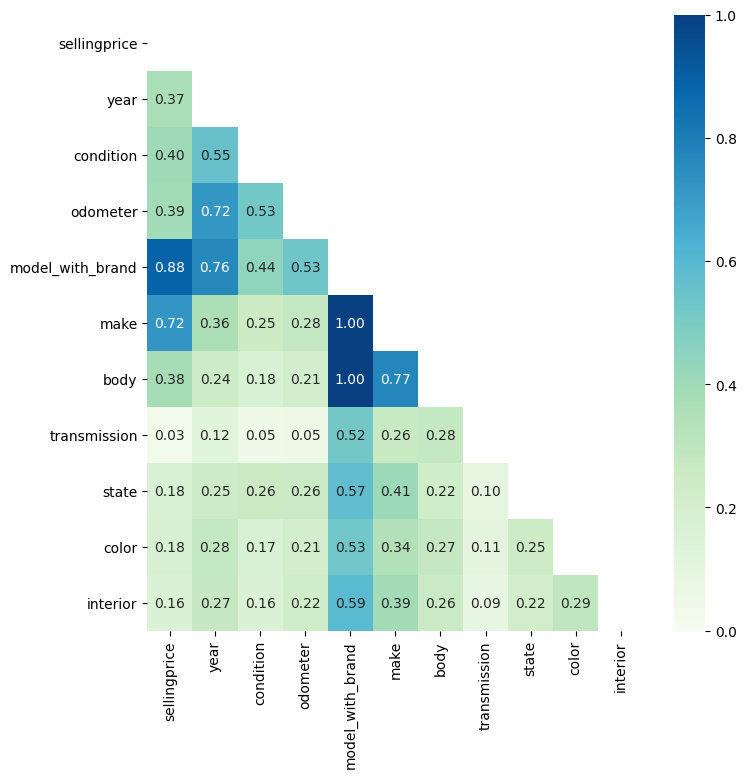

In [303]:
# сократили список признаков, так как фик не потянул все сразу
short_col_list = ['sellingprice', 'year', 'condition', 'odometer', 'model_with_brand', 'make', 
                  'body', 'transmission',  'state',  'color', 'interior']
plt.figure(figsize=(8, 8))
phi_corr_heatmap(train_df[short_col_list], ['sellingprice', 'year','condition', 'odometer'])

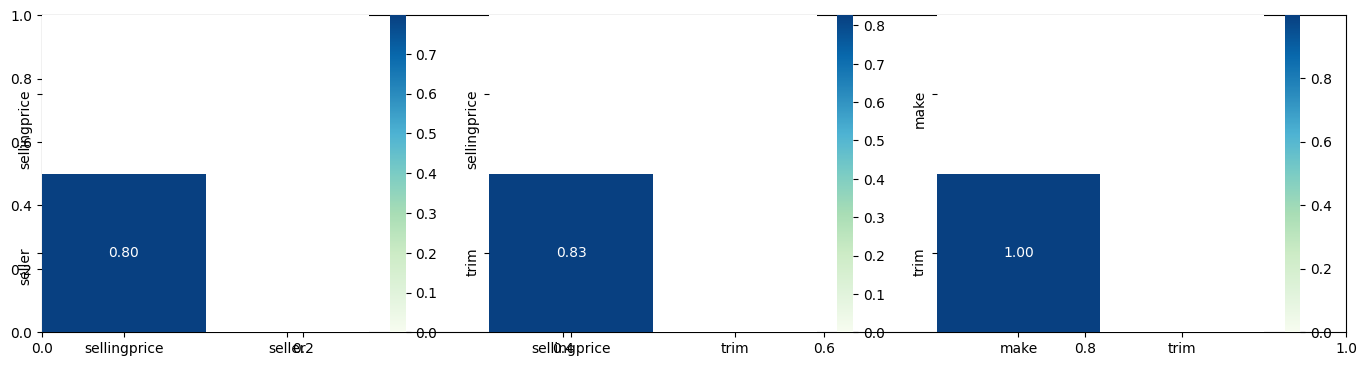

In [282]:
# продолжение

fig, axs = plt.subplots(figsize=(14, 4))
fig.add_subplot(131)
phi_corr_heatmap(train_df[['sellingprice', 'seller']], ['sellingprice'])
fig.add_subplot(132)
phi_corr_heatmap(train_df[['sellingprice', 'trim']], ['sellingprice'])

fig.add_subplot(133)
phi_corr_heatmap(train_df[['make', 'trim']]) # 
plt.tight_layout()

- Целевой признак цена имеет высокую коррреляцию с моделью, брендом, продавцом и комплектацией
- Модель в свою очередь коррелирует с остальными признаками: высоко с кузовом, трансмиссией, штатом и цветом, пробегом

Рассмотрим зависимости подробней

### `year`
У года и возраста будут прямо противополжные зависимости

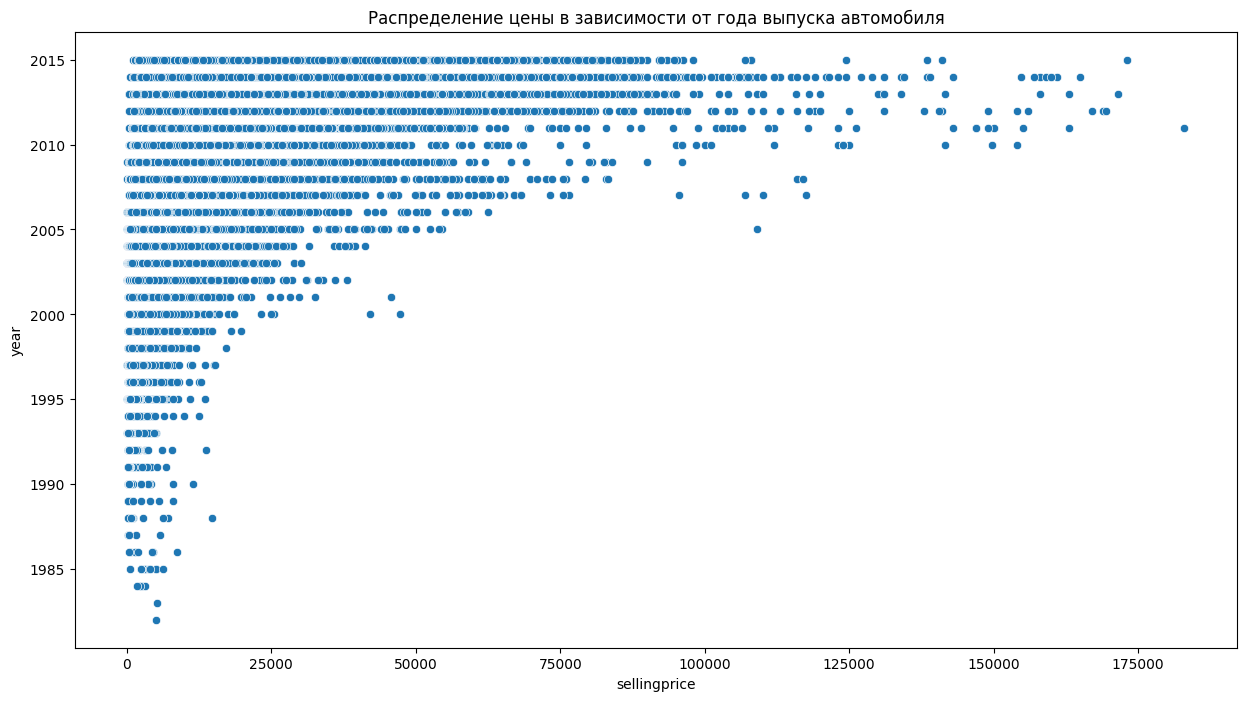

In [285]:
# диаграмма рассеяния цена-год
plt.figure(figsize=(15, 8))
sns.scatterplot(data=train_df, x=train_df['sellingprice'], y=train_df['year'])
plt.title("Распределение цены в зависимости от года выпуска автомобиля")
plt.show()

- Общая тенденция - чем позже год выпуска, тем выше цена. 
- Самые высокие значения в годах с 2009
- Автомобили 2015 года продаются по более низкой цене, чем предыдущие года. Возможные причины такого распределления: когда продают настолько свежую машину - попала в ДТП или ошибка ввода года


### `make`

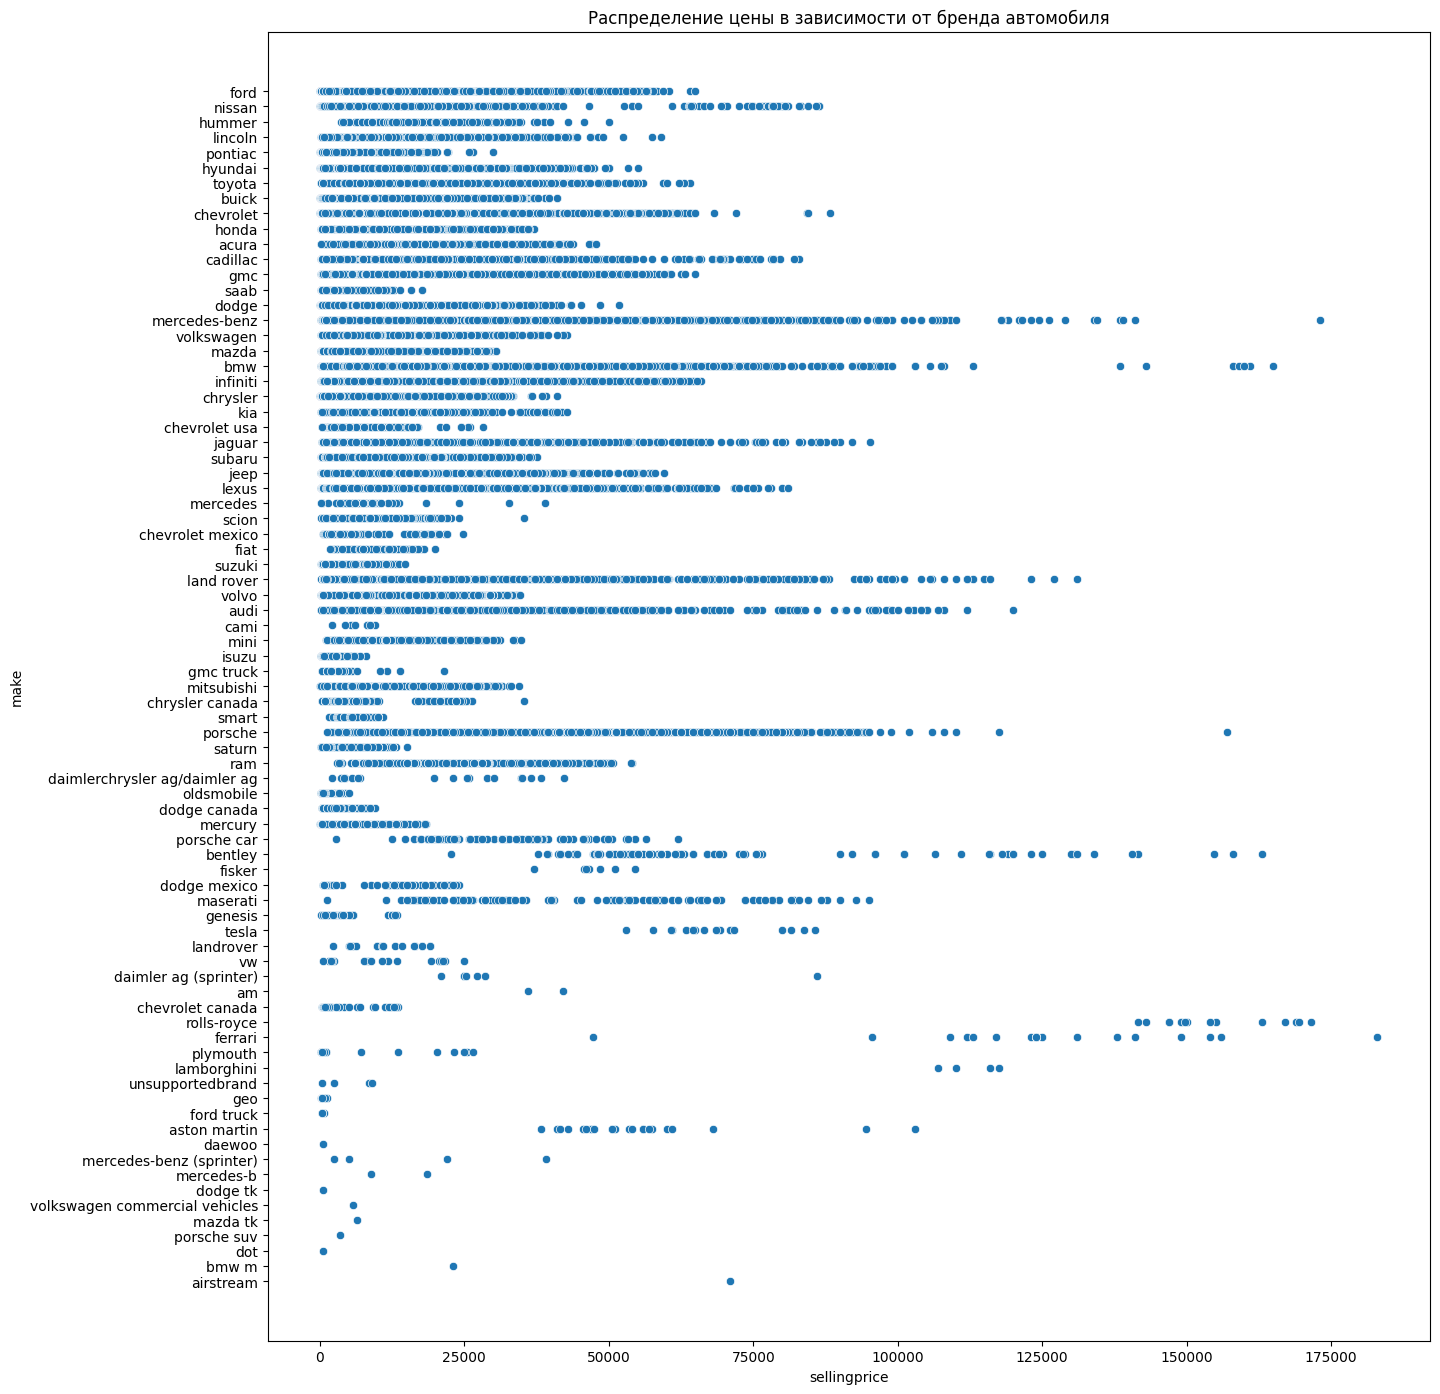

In [32]:
# график рассеяния цена-бренд
plt.figure(figsize=(15, 17))
sns.scatterplot(data = train_df, x='sellingprice', y='make')
plt.title('Распределение цены в зависимости от бренда автомобиля')
plt.show()

- Наблюдаем разные распределения цены в зависимости от бренда
- Самые высокие значения у премиальных брендов - вылетами не считаем

### `model`, `model_with_brand`


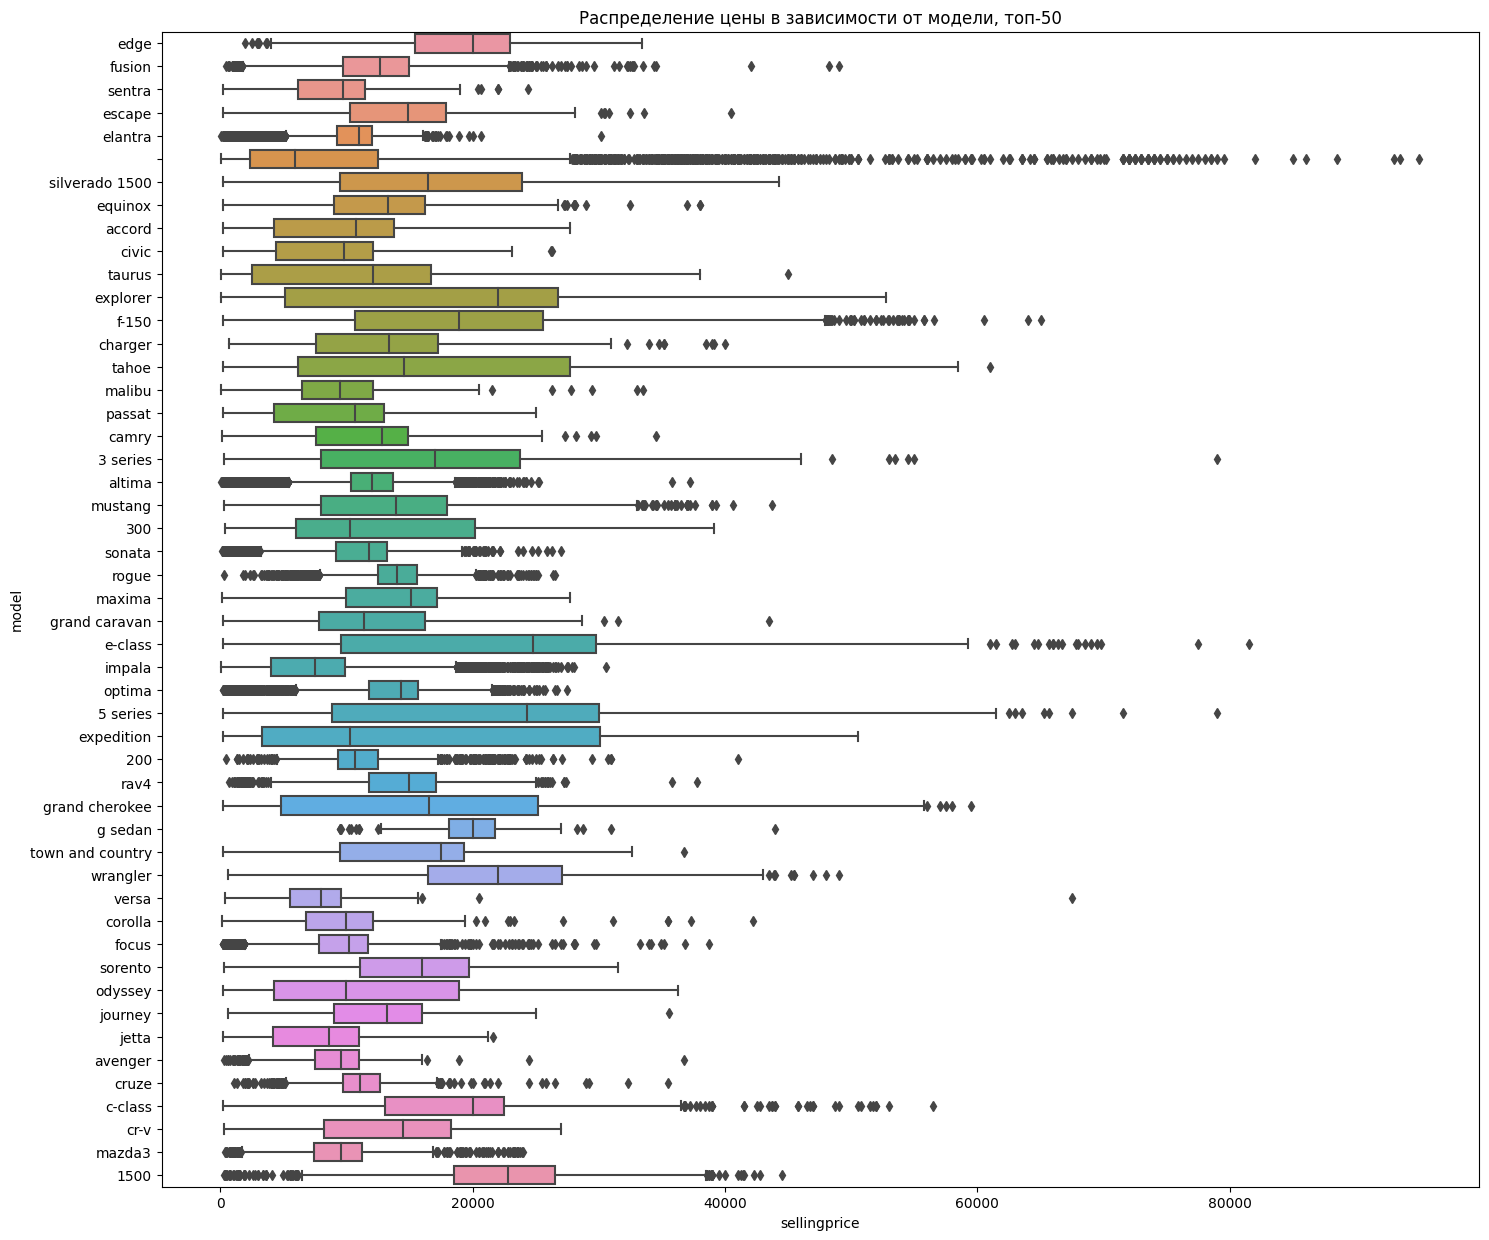

In [33]:
# гбоксплоты цена-модель, топ 50
plt.figure(figsize=(17,15))
model_top = train_df['model'].value_counts().nlargest(50).index
sns.boxplot(data=train_df[train_df['model'].isin(model_top)], x='sellingprice', y='model')
plt.title('Распределение цены в зависимости от модели, топ-50')
plt.show()

- У многих моделей максимальные значения  выбиваются из общей массы, будем считать это нормой
- В графе с пропущенными значениями моделей имеем имее наибольший разброс в предела 10 тыс. Для обучения заменим признак `model` на `model_with_brand`, тем самым разобьём группу с пропусками на группы с брендами

### `body`

Уберём дубликаты с разным написанием и объединим похожии категории 

In [287]:
# исправим вручную дубликат с разным написанием и присоединим небольшие похожие группы
train_df['body'] = train_df['body'].str.replace('regular-cab', 'regular cab')\
                                    .str.replace('cab plus 4', 'cab plus')\
                                    .str.replace('transit van', 'van')\
                                    .str.replace('ram van', 'van')


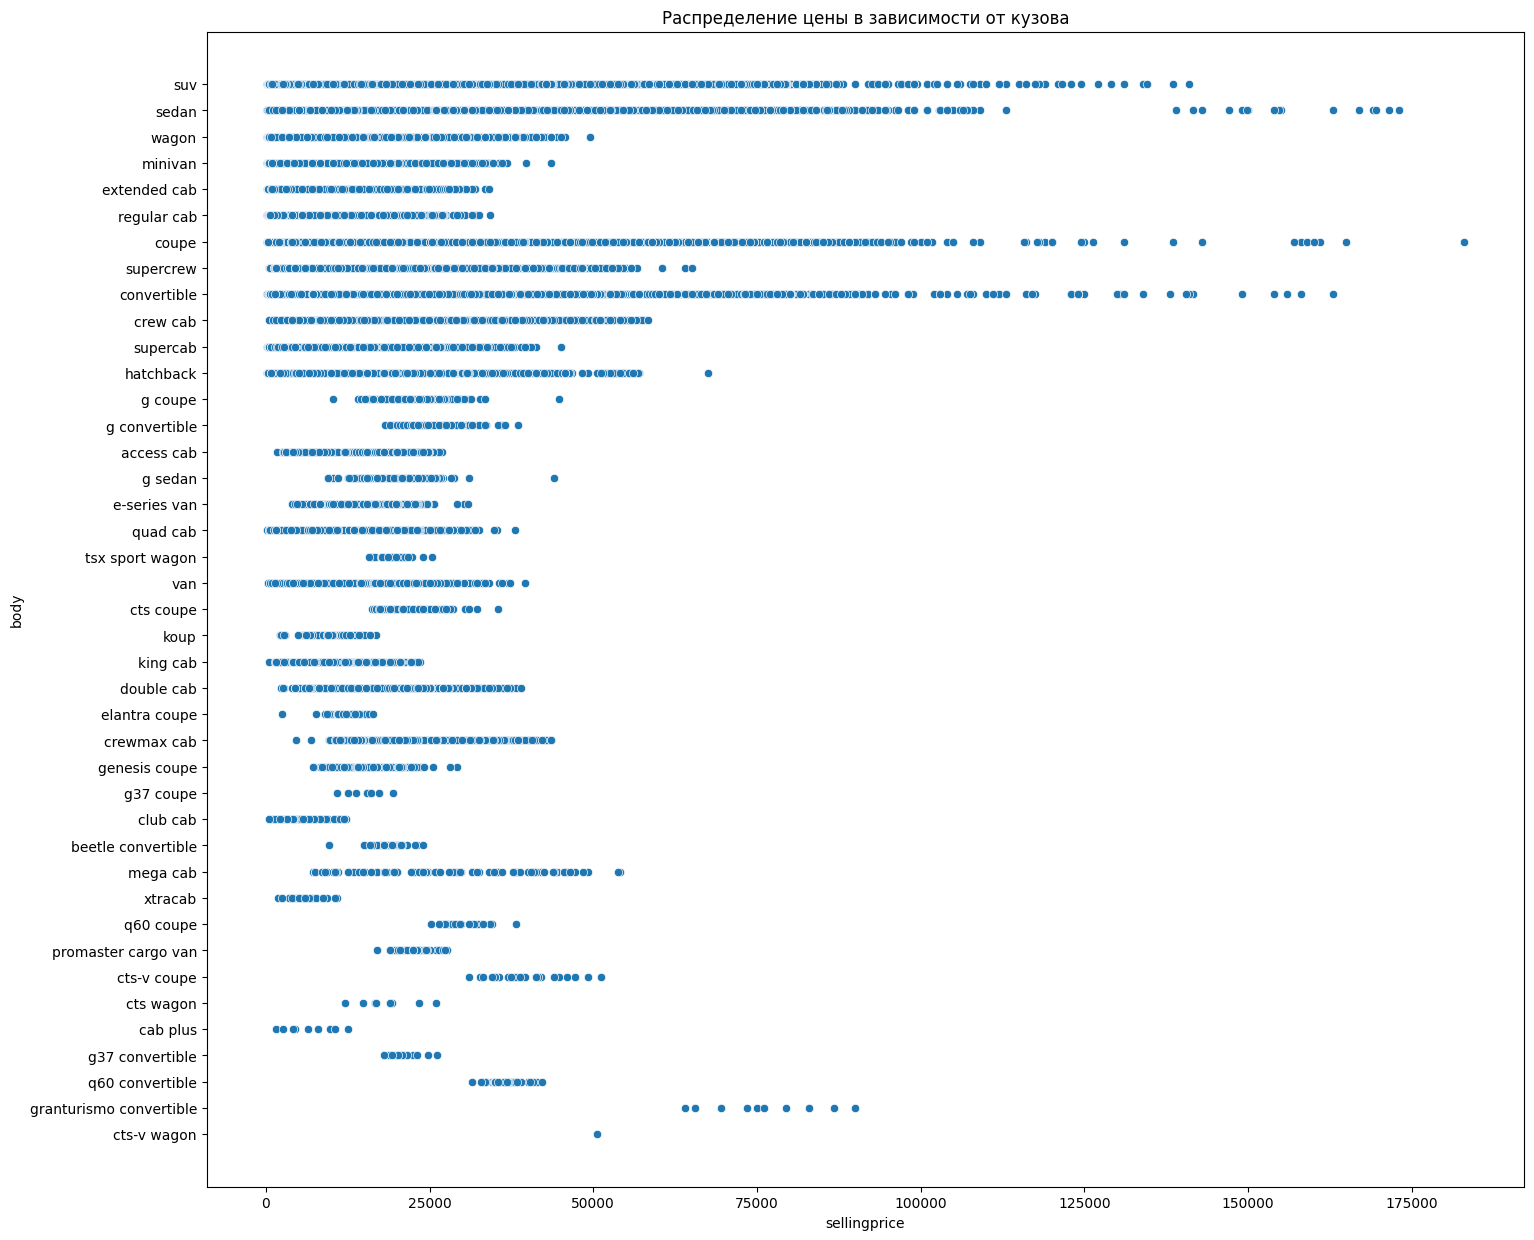

In [288]:
# график рассеяния цена-кузов
plt.figure(figsize=(17,15))
sns.scatterplot(data=train_df, x='sellingprice', y='body')
plt.title('Распределение цены в зависимости от кузова')
plt.show()

- В самых популярных типах кузова без уточнения большие разбросы цены
- В более редких кузовах и уточненных разброс меньше, дипазон более чёткий, это должно быть полезным при обучении.

### `trim`
Много уникальных значений - 1952.

In [37]:
# # # # подсчё сколько раз встречается каждое значение
# trim_value_counts = train_df['trim'].value_counts()

# # # замена значений, которые встречаются менее 3 раз, на "other"
# train_df['trim'] = train_df['trim'].apply(lambda x: 'other' if pd.notna(x) and trim_value_counts[x] < 2 else x)


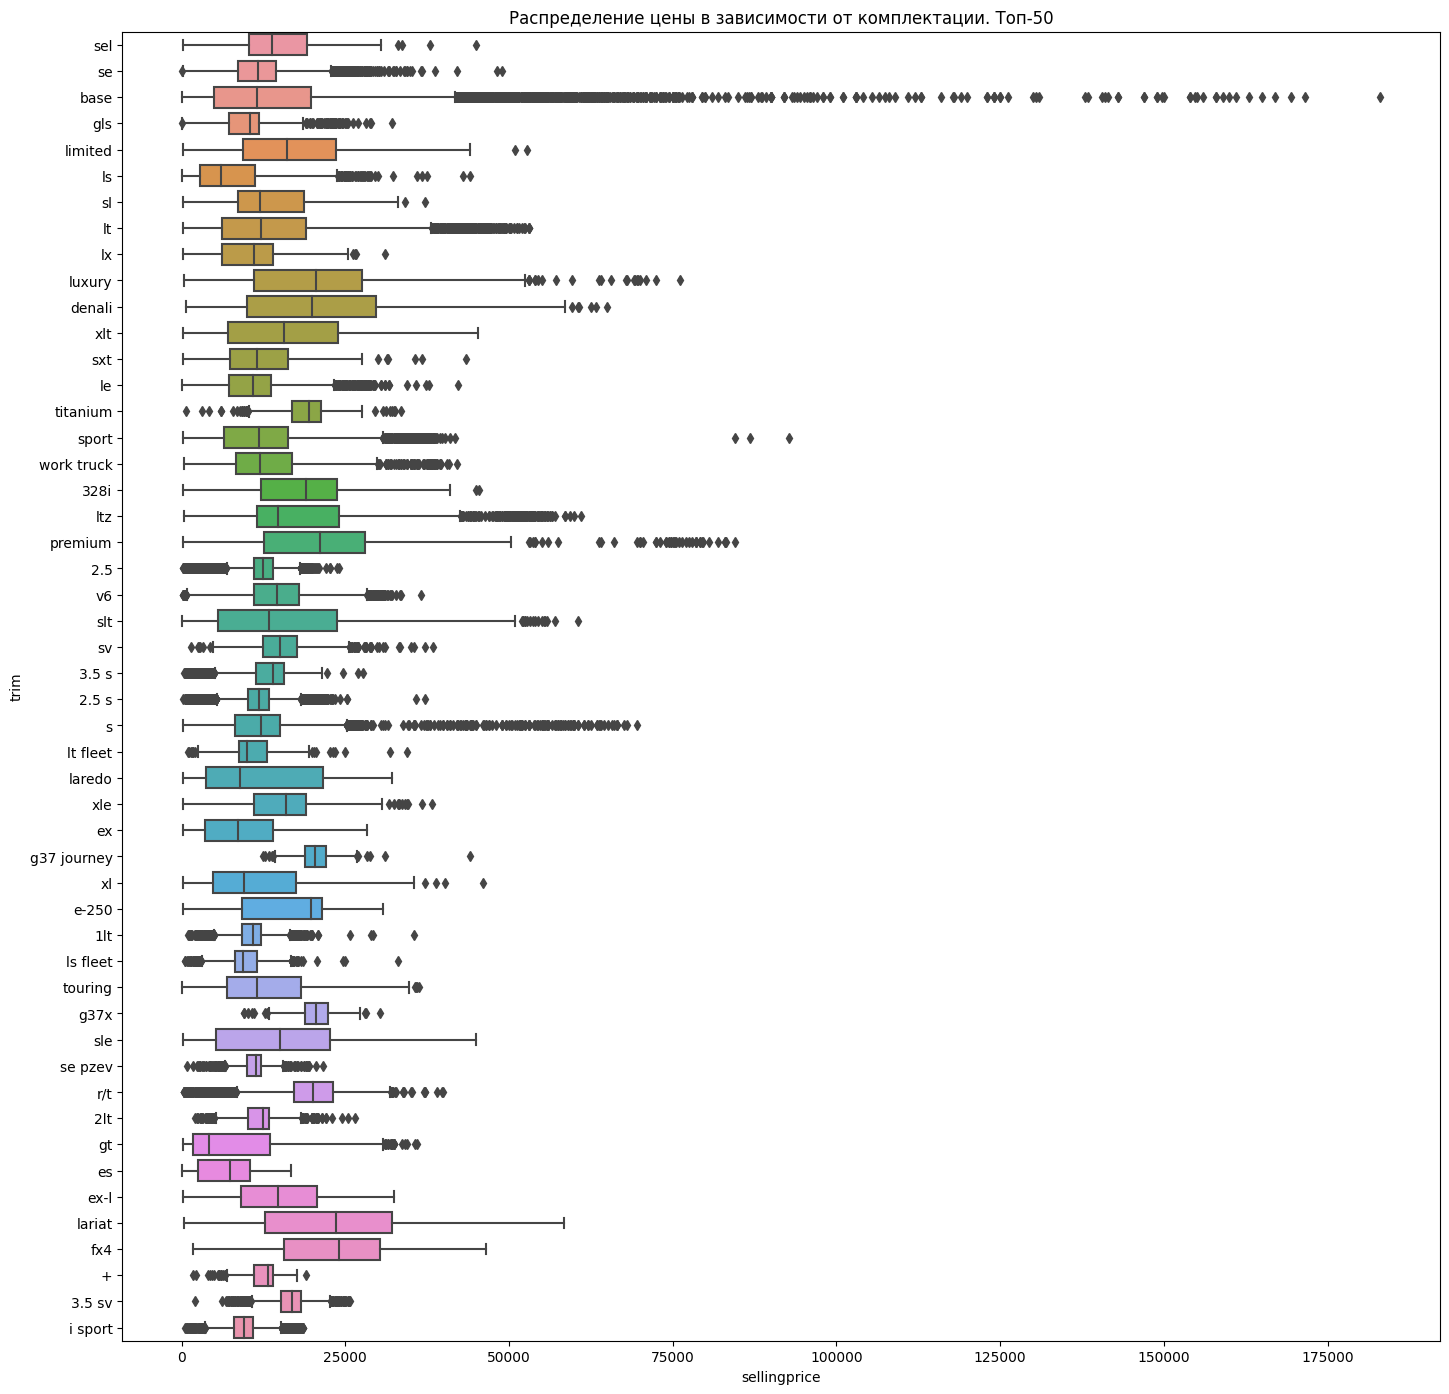

In [289]:
# график рассеяния цена-кузов
plt.figure(figsize=(17, 17))
top_trim = train_df['trim'].value_counts().nlargest(50).index
sns.boxplot(data=train_df[(train_df['trim'].isin(top_trim))], x='sellingprice', y='trim')
plt.title('Распределение цены в зависимости от комплектации. Топ-50')
plt.show()

- Большой разброс цены в самой распространённой комплектации base
- В более редких кузовах разброс меньше, дипазон более чёткий. Кажется, что это должно быть полезным при обучении. Попробуем TargetEncoding
- Пока решено не объединять в одну категорию редкие комплектации: если посмотреть распределение цены для комплектаций с всего 2 объектами, то они находятся рядом, а при объединении высокий разброс

### `transmission`
2 уникальных значения и больше всего  пропусков ~12%

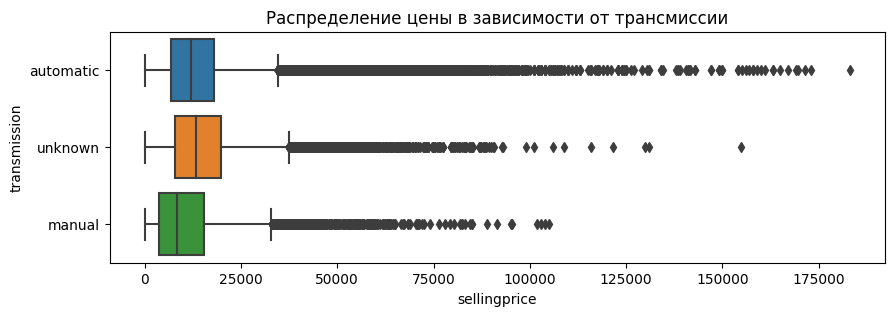

In [290]:
# график рассеяния цена-кузов
plt.figure(figsize=(10, 3))
top_trim = train_df['transmission'].value_counts().nlargest(50).index
sns.boxplot(data=(train_df.fillna('unknown')), x='sellingprice', y='transmission')
plt.title('Распределение цены в зависимости от трансмиссии')
plt.show()

- Диапазон и медиана цены автомобилей с автоматической коробкой передач  выше, чем с ручной. Но соотношение количества 85% и 3%

Взглянем на распределение цены от года с делением по трансмиссии

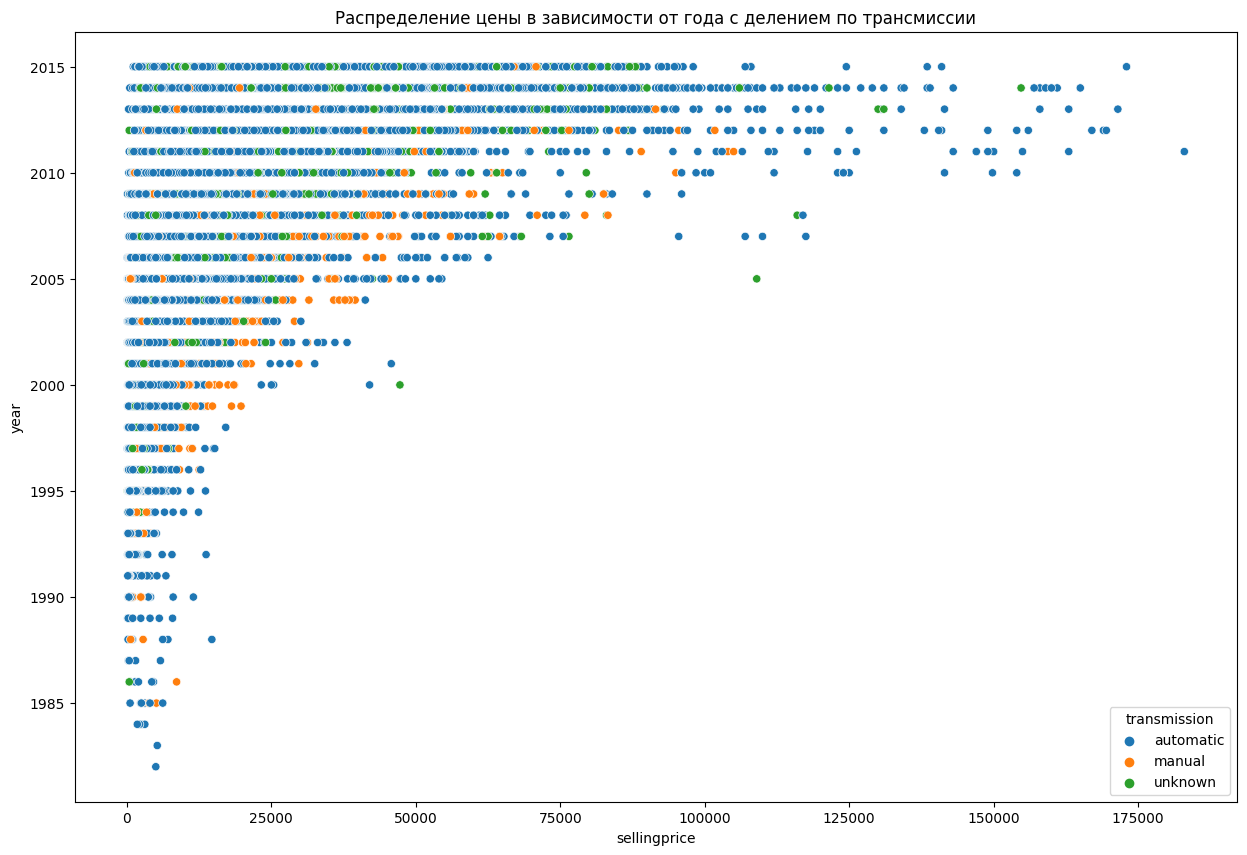

In [291]:
# график цена-год с делением по трансмиссии
plt.figure(figsize=(15, 10))
sns.scatterplot(data = train_df.fillna('unknown'), hue='transmission', x='sellingprice', y='year',
               hue_order=['automatic', 'manual', 'unknown'])
plt.title('Распределение цены в зависимости от года с делением по трансмиссии')
plt.show()

- Интересное наблюдение: до ~2010 годов цена автомобилей с ручной трансмиссией попадает в вернюю часть диапазона цен за год


### `seller`

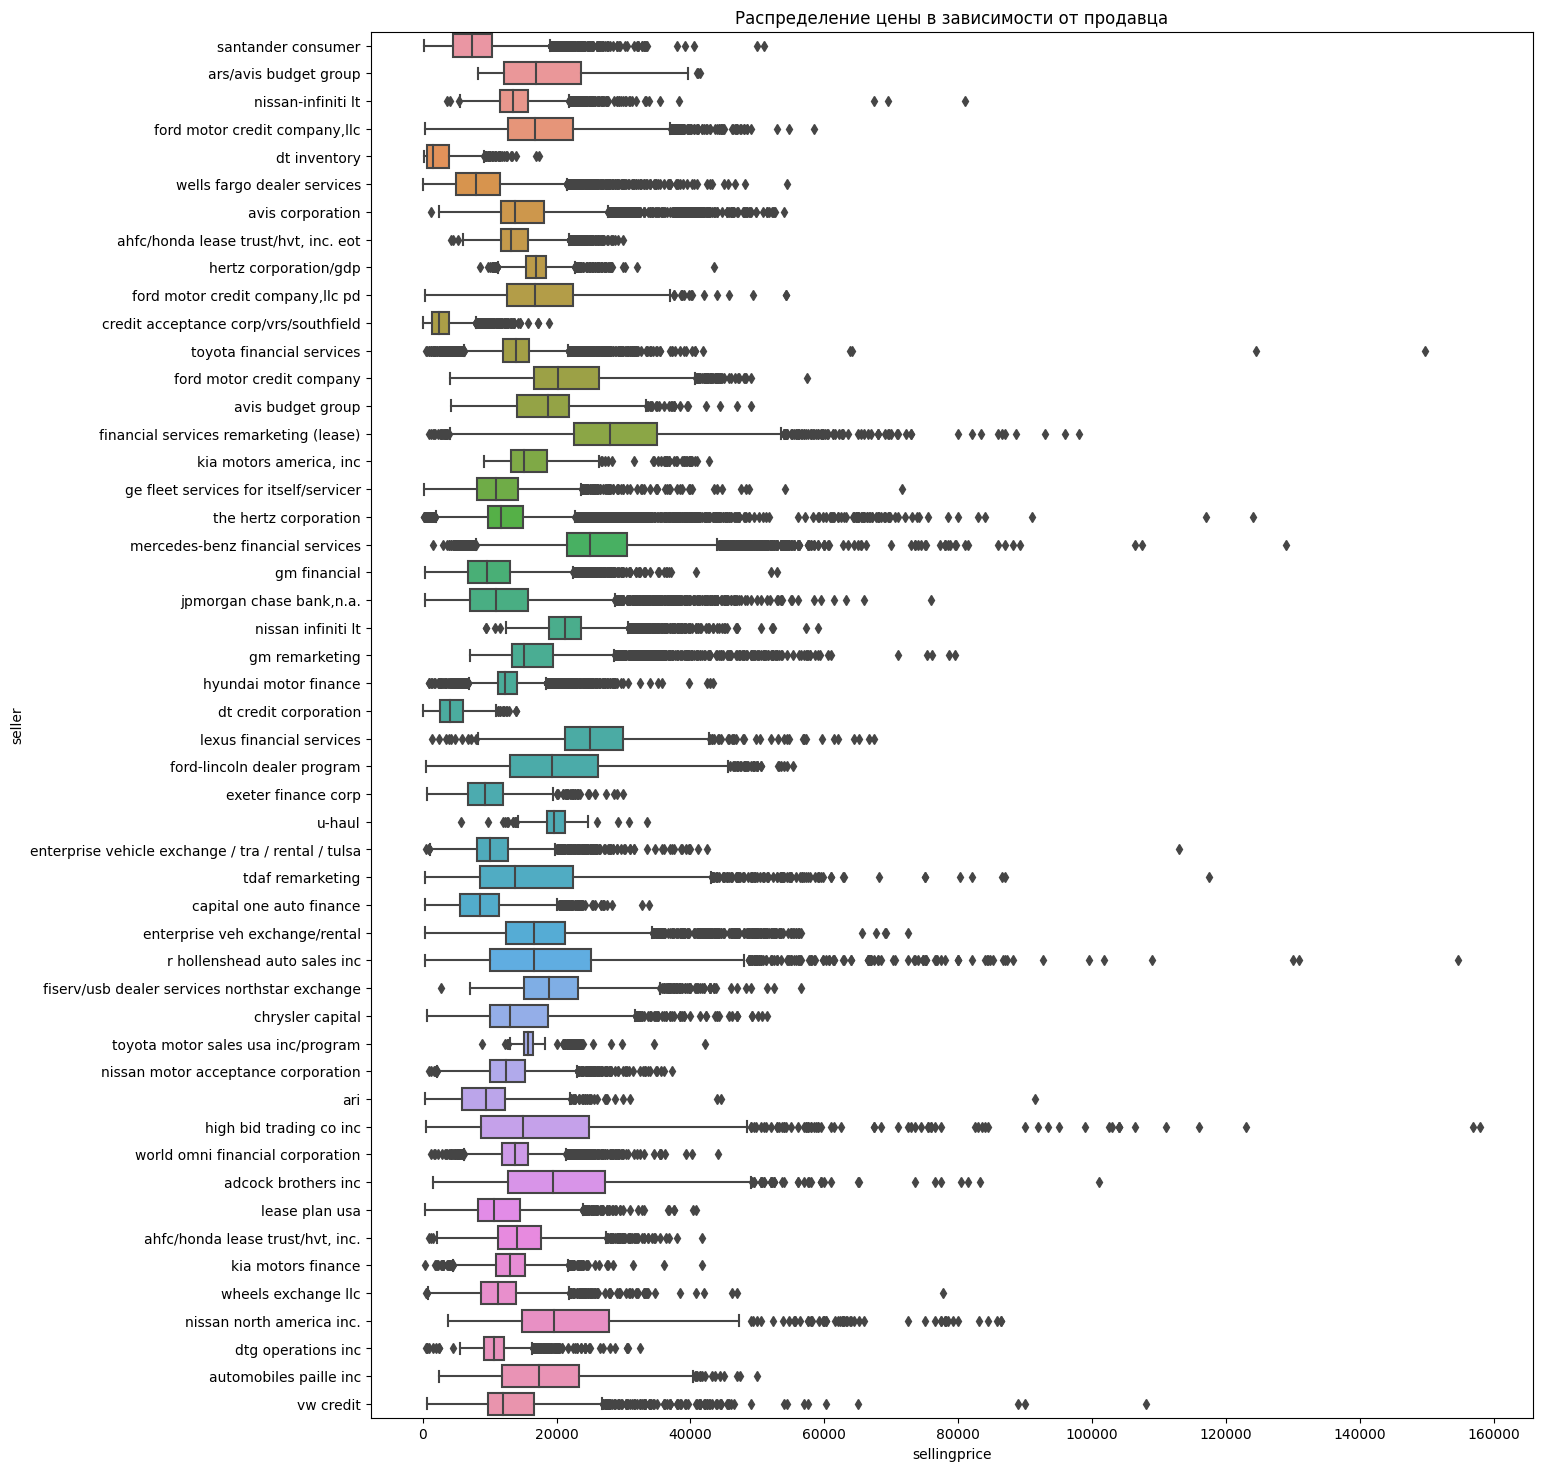

In [292]:
# график рассеяния цена-ghjlfdtw
plt.figure(figsize=(15, 18))
seller_top = train_df['seller'].value_counts().nlargest(50).index
sns.boxplot(data=train_df[train_df['seller'].isin(seller_top)], x='sellingprice', y='seller')
plt.title('Распределение цены в зависимости от продавца')
plt.show()

- Распределения цен по разным компаниям с разницей в медиане в 10-20 тыс. Используем TargetEncoder

### `odometer`

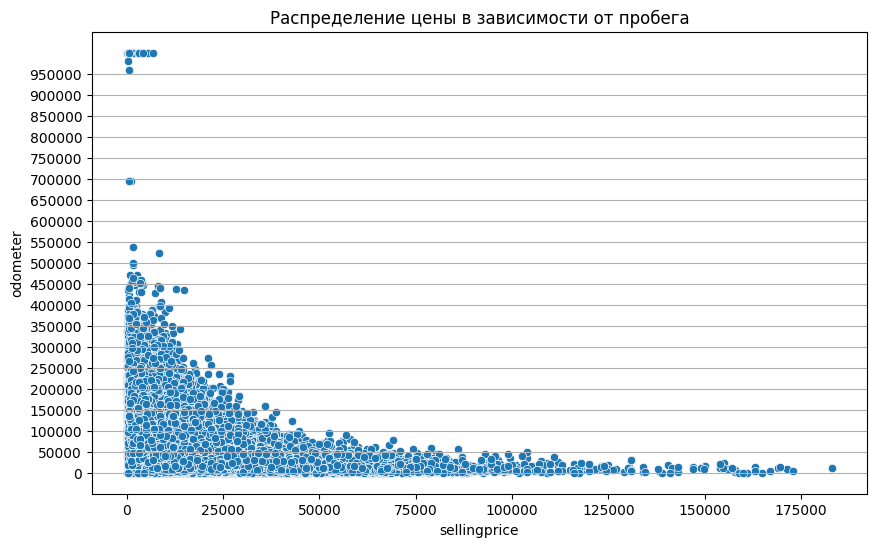

In [293]:
# график пробег-цена
plt.figure(figsize=(10, 6))
sns.scatterplot(data = train_df,  x='sellingprice', y='odometer')
plt.title('Распределение цены в зависимости от пробега')
plt.yticks(range(0, 999999, 50000))
plt.grid(axis='y')
plt.show()

- Ожидаемая тенденция: чем выше пробег, тем ниже цена

- Есть очень высокие значения - у максимума допустимого значения. Сомневаюсь, что автомобиль мог отъездить миллион километров, посмотрим

In [44]:
# объекты с максимальным пробегом
# train_df[train_df['odometer']>900000].T

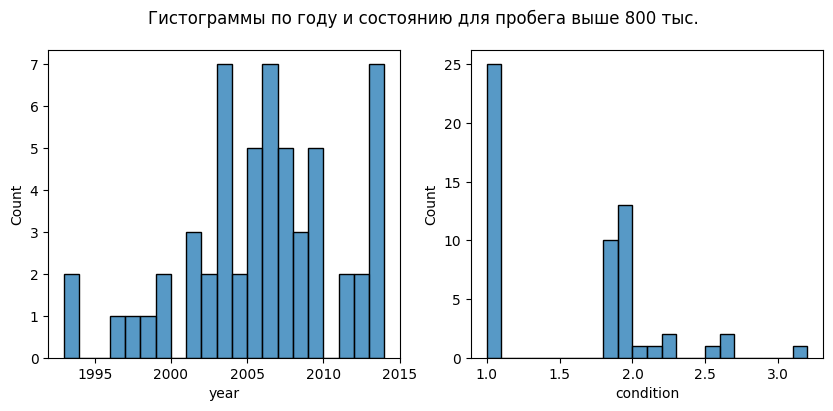

In [294]:
# объекты с пробегом выше 800 тыс. распределения года и состоянию
fig, axs = plt.subplots(1,2, figsize=(10, 4))
sns.histplot(train_df[train_df['odometer']>800000]['year'],  ax=axs[0], binwidth=1)
sns.histplot(train_df[train_df['odometer']>800000]['condition'], ax=axs[1], binwidth=0.1)
plt.suptitle('Гистограммы по году и состоянию для пробега выше 800 тыс.')
plt.show()

- Среди авто с высоким значением пробега есть автомобили "последних" годов выпуска, такой пробег маловероятен
- Оценка состояния машин с максимальным пробегом в общем низкая 

Предлагаю уменьшить максимальное значение, чтобы оно так сильно не выбивалось от основного распределения - сделать замену всех значений пробега выше 600 тыс. на 600 тыс.


In [295]:
# заменим значения пробега выше 600 тыс на 600 тыс
train_df['odometer'] = train_df['odometer'].apply(lambda x: 600000 if x>600000 else x)

### `condition`

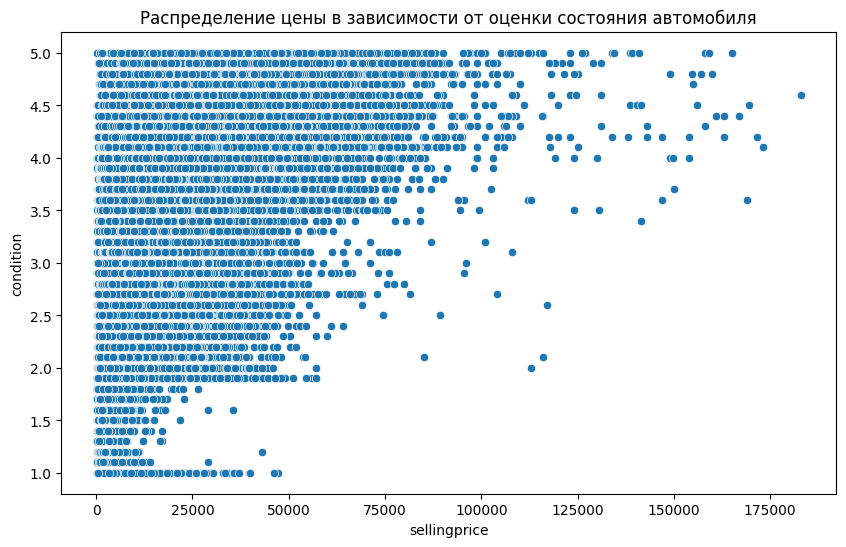

In [296]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = train_df,  x='sellingprice', y='condition')
plt.title('Распределение цены в зависимости от оценки состояния автомобиля')
plt.show()

- Закономерно: ниже оценка состояния - ниже цена

Интересное наблюдение: в датасете оценки состояния автомобилей до 1996 года округлены до целых значений:

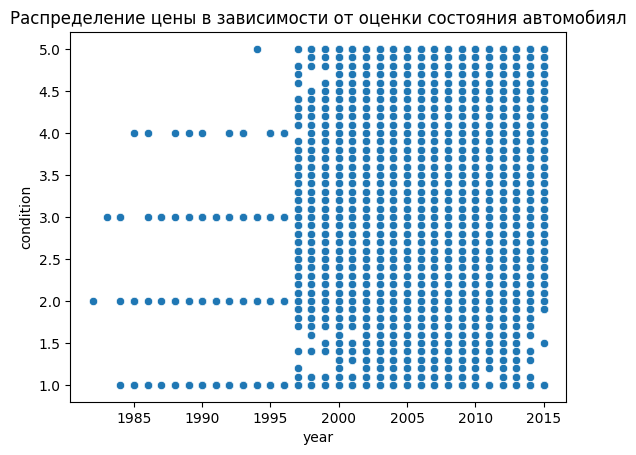

In [48]:
# распределение состояния по годам
sns.scatterplot(data = train_df,  x='year', y='condition')
plt.title('Распределение цены в зависимости от оценки состояния автомобиял')
plt.show()

### `state`

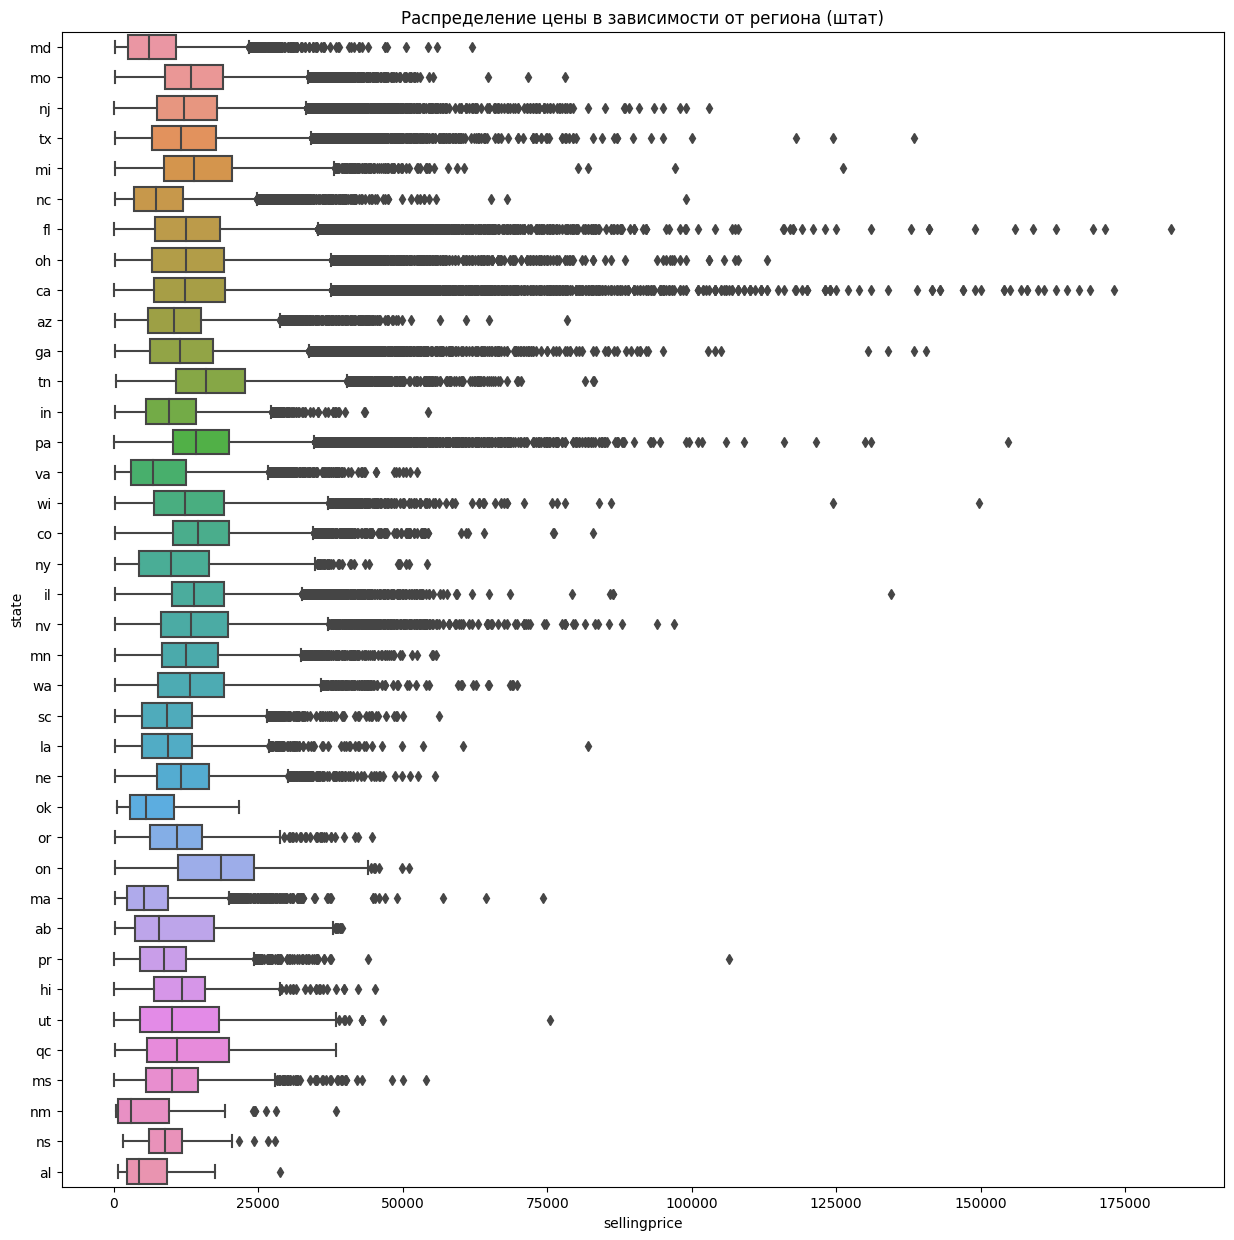

In [297]:
# график рассеяния цена-регион(штат)
plt.figure(figsize=(15, 15))
sns.boxplot(data=train_df, x='sellingprice', y='state')
plt.title('Распределение цены в зависимости от региона (штат)')
plt.show()

- Между регионами тоже отличаются диапазоны цен и медианы
- В Калифорнии и Филадельфии  продаютсясамые дорогие автомобили

### `color`, `interior`

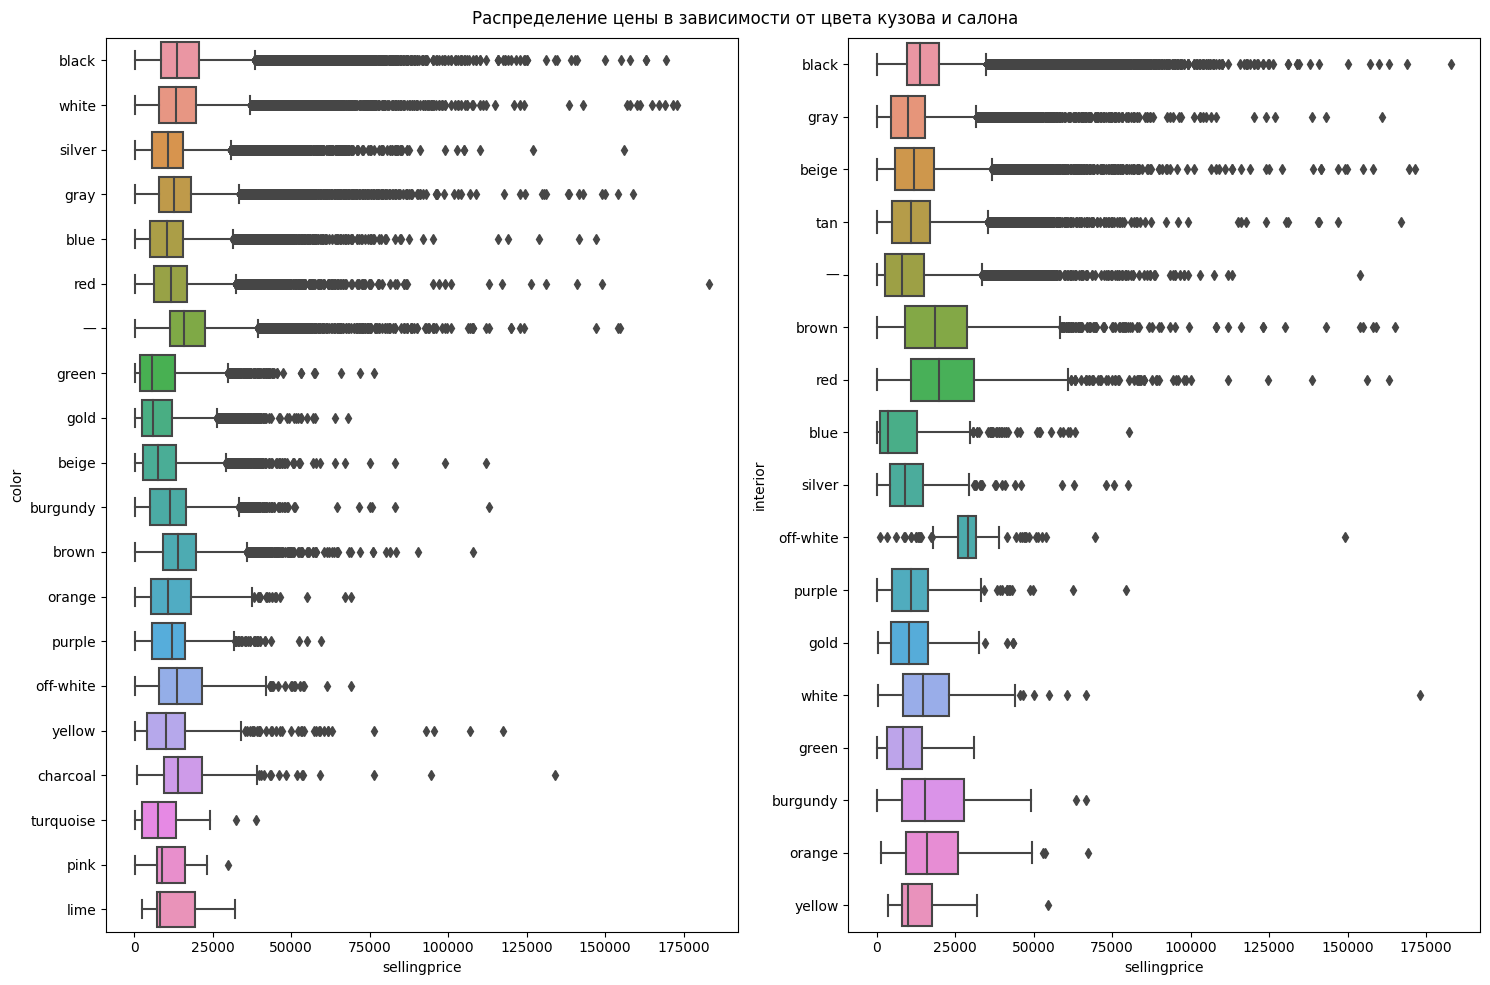

In [298]:
# график рассеяния цена-регион(штат)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
sns.boxplot(data=train_df, x='sellingprice', y='color', ax=axs[0], order=list(train_df['color'].value_counts().index))
sns.boxplot(data=train_df, x='sellingprice', y='interior', ax=axs[1], 
            order=list(train_df['interior'].value_counts().index))
plt.suptitle('Распределение цены в зависимости от цвета кузова и салона')
plt.tight_layout()
plt.show()

- Более редкие цвета реже встречаются среди дорогих авто

In [302]:
#оставшиеся пропуски
train_df.isna().sum().to_frame()

0
year                  0
make                  0
trim               8337
body              10393
transmission      51460
state                 0
condition          9405
odometer             68
color                 0
interior              0
seller                0
sellingprice          0
saledate              0
model_with_brand      0

---
В разделе EDA более глубоко проанализировали данные и взаимосвязи всех признаков с целевым, удалили "выбросы":
- Период дат продажи автомобилей 2014-01 - 2015-07. В обучающей и тестовой выборке распределение по дате одинаково.
- Корреляционный анализ:
    - все численны признаки `year`/`age`, `condition`. `odometer` имеют линейную зависимость с целевым
    - высокая корреляция пробега `odometer` и года выпуска `year` - *мультиколлинеарность*
    - высокая корреляция целевого признака с категориальными: модель, бренд, продавец и комплектация
    - Модель в свою очередь коррелирует с остальными признаками: высоко с кузовом, трансмиссией, штатом, цветом, пробегом
- Удалены выбросы:
    - максимум цены 230 тыс - ошибочное значение
    - цены ниже 100 у.е.
    - пробег выше 600 тыс. заменён на значение 600000
- Корректировки в значения:
    - изменено и объединено несколько значений в кузове `body`
- Удалим признак `model` , который дублируется дополненным `model_with_brand`, и признак с датой `saledate`

Выбрали обучающие признаки. В 5 из них остались пропуски. Учтём их далее в пайплайне с предобработкой.

## Подготовка выборок

Удалим ненужные для обучения признаки

In [331]:
# удалить дублирующий признак model и дату
train_df = train_df.drop(['model', 'saledate'], axis=1)
test_df = test_df.drop(['model', 'saledate'], axis=1)

In [305]:
# заготовим функцию для обработки новых данных перед предсказанием на основе EDA
def preprocess_new_data(df):
    """Функция для предобработки новых данных после preprocess_df перед предсказанием"""
    # исправим вручную дубликат с разным написанием и присоединим небольшие похожие группы
    df['body'] = df['body'].str.replace('regular-cab', 'regular cab')\
                                        .str.replace('cab plus 4', 'cab plus')\
                                        .str.replace('transit van', 'van')\
                                        .str.replace('ram van', 'van')



    # заменим значения пробега выше 600 тыс на 600 тыс
    df['odometer'] = df['odometer'].apply(lambda x: 600000 if x>600000 else x)
    return df

    # создать model_with_brand
    # удалить дублирующий признак model

In [306]:
# создать target
y_train = train_df['sellingprice']

# подготовить обучающую выборку для обучения
X_train = train_df.drop('sellingprice', axis=1)

# подготовить тестовую выборку
X_test = preprocess_new_data(test_df)

X_train.shape, y_train.shape, X_test.shape

((440233, 13), (440233,), (110058, 13))

## Моделирование 


### Кастомная метрика MAPE

In [56]:
# пользовательская метрика для обучения/валидации
def mape_func(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Создаем объект scorer с использованием make_scorer
mape_scorer = make_scorer(mape_func, greater_is_better=False)


### Подготовка к обучению

In [430]:
#### таблица для фиксирования результатов обучения
result_table = pd.DataFrame(columns=['MAPE'])
# установим количество знаков после запятой у float в таблицах
pd.set_option('display.float_format', '{:.3f}'.format)

Предобработка признаков перед обучением:
- масштабирование `StandardScaler` для численных признаков
- кодирование `TargetEncoder` + масштабирование `StandardScaler` для категориальных признаков кроме трансмиссии (кодирование пропусков)
- кодирование `OneHotEncoder` для `transmission` (кодирование пропусков)
- заполнение пропусков `KNNImputer` в чиловых признаках `condition`, `odometer`

In [426]:
# признаки
# ЧИСЛЕННЫЕ
# num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features = ['year', 'condition', 'odometer'] 
# КАТЕГОРИАЛЬНЫЕ
# cat_features = X_train.select_dtypes(include=['object']).columns.to_list()
cat_features = ['make', 'trim', 'body','state','color','interior', 'seller', 'model_with_brand']
# для OHE
ohe_features = ['transmission']
# С ПРОПУСКАМИ
feature_to_impute = ['transmission', 'odometer', 'body', 'trim', 'condition']

In [365]:
# фиксированное разделение на фолды
kf = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

def randomized_search_model(X_train, model):
    """Функция для кросс-валидации, обучения и подбора ГП RandomizedSearchCV"""

    # GridRandomizerCV
    randomized_search_tune = RandomizedSearchCV(
                                     model, 
                                     parameters_cb, 
                                     cv=kf, 
                                     n_iter=5,
                                     scoring=mape_scorer, 
                                     return_train_score=True,
                                     verbose=1,
                                     n_jobs=-1, 
                                     error_score=0, # пропустить ошибку при недопустимой комбинации ГП
                                     random_state=RANDOM_STATE
                                           ) 
    # обучение и подбор
    randomized_search_tune.fit(X_train, y_train)
    return randomized_search_tune


# расчёт метрики MAPE на кросс-валидации (упрощенная схема без подбора ГП)
def cross_val_score_mape(X_train, model):
    """Функция для расчёта метрики MAPE на кросс-валидации"""
    score = cross_val_score(model, X_train, y_train, cv=kf, 
                              scoring='neg_mean_absolute_percentage_error').mean()
    return score

### Линейная модель Lasso
Между целевым признаком и числовыми выявлены линейные зависимости. Попробуем линейную модель с регуляризацией.  
Учтитываем, что имеем мультиколлинеарность между пробегом `odometer` и годом выпуска `year`.

Предобработка признаков перед обучением линейной модели:
- масштабирование `StandardScaler` для численных признаков
- кодирование `TargetEncoder` + масштабирование `StandardScaler` для категориальных признаков кроме трансмиссии (кодирование пропусков)
- кодирование `OneHotEncoder` для `transmission` (кодирование пропусков)
- заполнение пропусков `SimpleImputer` в чиловых признаках `condition`, `odometer`
- удалить коррелирующие признаки 

In [432]:
# ПРЕДОБРАБОТКА ПРИЗНАКОВ
# последовательная обработка категориальных признаков кодирование TargetEncoder и далее масштабирование
target_enc_scaler = Pipeline(steps=[
    ('target_enc', TargetEncoder(smoothing=0.2)),
    ('scaler', StandardScaler())
])

# приготовим список признаков специально для нинейной модели
num_features_lin = num_features


# комбинированный препроцессор для числовых и категориальных переменных, на выходе все значения числовые и масштабированные
preprocessor_lin = ColumnTransformer(
transformers=[
     ('scaler', StandardScaler(), num_features_lin),
    ('target_enc', target_enc_scaler, cat_features),
    ('ohe_enc', OneHotEncoder(drop=[np.nan], handle_unknown='ignore'), ohe_feature) #sparse_output?
])

# определяем МОДЕЛЬ lasso
model_lasso = Lasso()

# ГП для подбора
parameters_lasso = {'model__alpha': [0.005, 0.01, 0.1, 1.0, 10.0]
#                     'model__tol': [0.0001, 0.001, 0.01]
                    }


# ссоздаём ПАЙПЛАЙН  
pipeline_lasso = Pipeline(steps=[('preprocessor', preprocessor_lin),
#                                  ('imputer', KNNImputer(n_neighbors=3)),
                                 ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
                                 ('model', model_lasso)])
# обучение и подбор
# randomized_search_model(X_train, model_lasso)

# оценим модель
result_table.loc['Lasso + preprocessing'] = cross_val_score_mape(X_train, pipeline_lasso)


Оценим корреляцию предобработанных признаков  
Предобработаем выборки -> `X_train_enc`, `X_test_enc` (есть пропуски)

In [450]:
# предобработка данных препроцессором для линейной модели, оценка корреляции
X_train_enc = preprocessor_lin.fit_transform(X_train, y_train)
X_train_enc = pd.DataFrame(X_train_enc, columns=preprocessor_lin.get_feature_names_out(), index=X_train.index)


# сразу заготовим предобработанную тестовую выборку
X_test_enc = preprocessor_lin.transform(X_test)
X_test_enc = pd.DataFrame(X_test_enc, columns=preprocessor_lin.get_feature_names_out(), index=X_test.index)

X_train_enc.corr(method='spearman').abs().style.background_gradient().set_precision(2)


Подтверждаем только высоую корреляцию между годом выпуска и пробегом. Попробуем обучение без каждого признака

In [431]:
# удалим год и проведем валидацию
num_features_lin = [col for col in num_features if col not in [ 'year']]
result_table.loc['Lasso + preprocessing - year'] = cross_val_score_mape(X_train, pipeline_lasso)

# удалим пробег и оценим метрику
num_features_lin = [col for col in num_features if col not in [ 'odometer']]
result_table.loc['Lasso + preprocessing - odometer'] = cross_val_score_mape(X_train, pipeline_lasso)
result_table

MAPE
Lasso + preprocessing - year     -0.622
Lasso + preprocessing - odometer -0.622

Разницы в качестве не видим, возьмём полный набор признаков и обучим модель, чтобы оценить веса

In [435]:
# обучение на полном датасете
pipeline_lasso.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['year', 'condition',
                                                   'odometer']),
                                                 ('target_enc',
                                                  Pipeline(steps=[('target_enc',
                                                                   TargetEncoder(smoothing=0.2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['make', 'trim', 'body',
                                                   'state', 'color', 'interior',
                                                   'seller',
                                                   'model_with_brand']),
                                                 ('ohe_enc',
                                                  OneHotEncoder(drop=[nan],
                                                                handle_unknown='ignore'),
                                                  ['transmission'])])),
                ('imputer', SimpleImputer(fill_value=-1, strategy='constant')),
                ('model', Lasso())])

In [446]:
# достаём коэффициенты
model_coefs = pipeline_lasso.steps[2][1].coef_

# названия признаков
all_feature_names = pipeline_lasso.named_steps['preprocessor'].get_feature_names_out().tolist()
# убираем префиксы предобработки
all_feature_names = [re.sub(r".*__", "", col) for col in all_feature_names]

pd.DataFrame(abs(model_coefs), index=all_feature_names, columns=['Coef'])\
                                .sort_values(by='Coef', ascending=False).style.background_gradient()

Наиболее важным признаком для предсказания в модели Lasso является модель автомобиля. Далее комплектация и пробег. 
Менее, но значимо - год, продавец, состояние и кузов. Год получил меньшую значимость, чем пробег. 

Линейная модель даёт очень высокое значение метрики. Далее сразу испытаем градиентный бустинг из библиотеки CatBoost.

### CatBoostRegressor
Предобработка признаков перед обучением градиентного бустинга CatBoostRegressor:
- масштабирование `StandardScaler` для численных признаков
- кодирование `TargetEncoder` + масштабирование `StandardScaler` для категориальных признаков кроме трансмиссии (кодирование пропусков)
- кодирование `OneHotEncoder` для `transmission` (кодирование пропусков)
- оставим пропуски в  `condition`, `odometer`


In [455]:
# комбинированный препроцессор для числовых и категориальных переменных
preprocessor_cb = ColumnTransformer(
transformers=[
    ('scaler', StandardScaler(), num_features),
    ('target_enc', TargetEncoder(smoothing=0.2, handle_missing='return_nan'), cat_features),
    ('ohe_enc', OneHotEncoder(drop=[np.nan], handle_unknown='ignore'), ohe_features) #sparse_output
])

# определяем модель
model_cb = cb.CatBoostRegressor(early_stopping_rounds=20, random_state=RANDOM_STATE, silent=True)

# набор гиперпараметров для CatBoostRegressorс диапазонами для перебора
parameters_cb = {
                'model__random_state' : [RANDOM_STATE],
                'model__iterations': [100, 250, 500, 800],
                'model__max_depth': [2, 3, 5, 8 ],
                'model__learning_rate': np.arange(0.001, 1, 0.05),
                'model__early_stopping_rounds' : [20]
                }
# ссоздаём пайплайн  
pipeline_cb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model_cb)])
                    

In [456]:

result_table.loc['CB + no preprocessing'] = -cross_val_score_mape(X_train, pipeline_cb)
result_table

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAPE
Lasso + preprocessing - year     -0.622
Lasso + preprocessing - odometer -0.622
Lasso + preprocessing            -0.622
CB + no preprocessing            -0.180

Результат значительно лучше (подозрительно).  

#### Важность признаков
Оценим важность признаков с помощью библиотеки SHAP

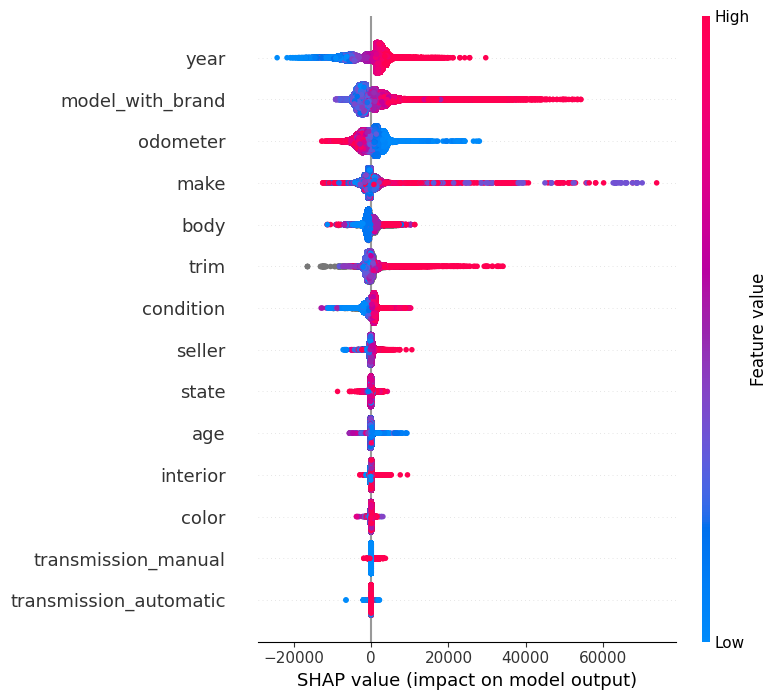

In [137]:
# график важности признаков
explainer = shap.TreeExplainer(model_pipe_cb.best_estimator_[1])
shap_value = explainer.shap_values(X_train_enc)
shap.summary_plot(shap_value, X_train_enc, max_display=25, auto_size_plot=True)

Отметим, что почти все категориальные признаки  закодированы TargetEncoder.

- Наиболее значимы вклад в предсказания дают признаки: make, model, year, trim, odometer
- Менее значимый, но заметный condition, body, age, seller
- transmission не даёт вклад
- state неоднозначный
- Высокие значения цвета интерьера interior вносят вклад в предсказание более высокой цены, цвет кузова color меньше

Я бы попробовала варианты обучения:
- без `age`
- без `year`
- без `transmission`

Но как-нибудь потом

Далее попробуем поэкпериментировать с данными при обучении модели CatBoost



Кэтбуст
- ~~обучить с предобработкой~~
- оценить важность признаков!!! куда?
- попробовать без обработки
- попробовать дополнить разными фичами обучение:
    - импутер
    - кластеризация

#### Обучение без предобработки
Передадим в модель данные без предобработки

In [477]:
preprocessor_cb_no_prep = ColumnTransformer(
transformers=[
     ('scaler', 'passthrough', num_features),
    ('target_enc', 'passthrough', cat_features),
    ('ohe_enc', 'passthrough', ohe_features) #sparse_output
])
model_cb_no_prep = cb.CatBoostRegressor(early_stopping_rounds=20, random_state=RANDOM_STATE)

# ссоздаём пайплайн без предобработки 
pipeline_cb_no_prep = Pipeline(steps=[
                            ('preprocessor', preprocessor_cb_no_prep),
                              ('model', model_cb)])
                    

In [478]:

result_table.loc['CB + no preprocessing'] = -cross_val_score_mape(X_train, pipeline_cb_no_prep)


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'ford'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py", line 1907, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py", line 1189, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py", line 628, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
  File "/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py", line 1171, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
  File "_catboost.pyx", line 3755, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3818, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3728, in _catboost._PoolBase._init_objects_order_layout_pool
  File "_catboost.pyx", line 3261, in _catboost._set_data
  File "_catboost.pyx", line 3244, in _catboost._set_data_from_generic_matrix
  File "_catboost.pyx", line 2169, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="ford": Cannot convert 'b'ford'' to float


вывод

### KNNImputer, обучение на данных без пропусков
Попробуем заполнить пропуски с помощью интрумента KNNImputer и оценить как это повлияет на метрику. Здесь используем закодированную выборк
~~Для этого к закодированному датасету присоединим целевой признак ~~

In [ ]:
# ссоздаём пайплайн c заполнением пропусков
pipeline_cb_imp = Pipeline(steps=[
                            ('preprocessor', preprocessor_cb),
                            ('imputer', KNNImputer(n_neighbors=5)),
                              ('model', model_cb)])

result_table.loc['CB + preprocessing + imputer'] = -cross_val_score_mape(X_train, pipeline_cb_imp)


In [169]:
# KNNImputer вручную

# # Выбираем столбцы, которые будем использовать для заполнения
# columns_to_use = ['year', 'condition', 'odometer', 'make', 'model_with_brand', 'trim', 'body',
#         'color', 'interior', 'seller']
# # Создаем экземпляр KNNImputer
# imputer = KNNImputer(n_neighbors=5)

# X_train_imp = X_train.copy()
# # Заполняем пропуски в столбце 'transmission' на основе соседей в выбранных столбцах
# X_train_imp[columns_to_use]  = imputer.fit_transform(X_train_enc[columns_to_use])

# # заполним пропуски в тестовой выборке
# X_test_imp = X_test_enc.copy()
# X_test_imp[columns_to_use] = imputer.transform(X_test_enc[columns_to_use])

# X_test_enc.isna().sum(), X_train_imp.isna().sum()

CPU times: user 17min 54s, sys: 5min 15s, total: 23min 9s
Wall time: 24min 29s


## Кластеризация для создания нового признака
Добавим новый признак `cluster` с помощью алгоритма кластеризации KMeans, который разделит всех пользователей на несколько групп, объединённых общим набором признаков. Обучение будет проводиться на предобработанной тренировочной выборке без целевого признака


Сначала подберём оптимальное количество кластеров с помощью метода локтя

In [ ]:
# список для фиксирования фунции потерь для моделей с разным количеством кластеров
distortion = []
# испытаем модели с 1-10 кластерами
K = range(1, 15)
for k in K:
    model_km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    model_km.fit(X_train_imp)
    distortion.append(model_km.inertia_)
# график  
plt.figure(figsize=(6, 4))
plt.plot(K, distortion, 'bx-')
plt.xticks(range(k+1))
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.title('Зависимость целевой функции от количества кластеров')
plt.show()

Выбираем 5 кластера и генерируем новый признак с помощью метода К-средних на тренировочной выборке.  
Признак относится к категориальным, поэтому сразу изменим на строковый тип.

In [ ]:
# определяем модель
model_kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE)

# проводим кластеризацию объектов, обучение на train
model_kmeans.fit(X_train_imp)

# к обучающей выборке добавляем новый признак с номерами кластеров, переводим в строковый тип данных 
X_train_cluster = X_train.copy()
X_train_cluster['cluster'] = model_kmeans.labels_

# оценим результат
X_train_cluster['cluster'].value_counts()
X_train_cluster.head()

In [ ]:
X_test_cluster = X_test.copy()
X_test_cluster['cluster'] = model_kmeans.predict(X_test_imp)
X_test_cluster

Проанализируем взаимосвязи кластеров с остальными данными в обучающей выборке

In [ ]:
# корреляция Спирмена
display(pd.concat([X_train_cluster, y_train], axis=1
         ).corr(method='spearman').abs().style.background_gradient(cmap='GnBu'))
# # фи-коэффициенты корреляции
# display(pd.concat([X_train, y_train], axis=1
#          ).phik_matrix()['cluster'].to_frame().style.background_gradient(cmap='GnBu'))

In [324]:
pd.concat([X_train_cluster, y_train], axis=1).phik_matrix().style.background_gradient(cmap='GnBu')

interval columns not set, guessing: ['year', 'condition', 'odometer', 'age', 'make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller', 'transmission_automatic', 'transmission_manual', 'sellingprice']


In [ ]:
result_table.loc['CB + preprocessing + cluster'] = -cross_val_score_mape(X_train_cluster, pipeline_cb)
result_table

Выбрать лучшую модель

## Полное обучение
Проведем обучение лучшей модели на полном датасете X_train (без кросс-валидации)

In [ ]:
pipeline_cb.fit(X_train, y_train)

Сгенерируем предсказания на тестовой выборке

In [119]:
# предсказания  
y_pred = pipeline_cb.predict(X_test)
pd.DataFrame({'vin': X_test_cod.index, 'sellingprice': y_pred}).head(3)

vin  sellingprice
0  1g6dp567450124779       5126.44
1  1gtw7fca7e1902207      21425.71
2  jn8az1mw6dw303497      19856.59

In [120]:
# сохранить предсказания для сабмита
pd.DataFrame({'vin': X_test_cod.index, 'sellingprice': y_pred}).to_csv('submission.csv', index=False)